<a href="https://colab.research.google.com/github/Motunrayo244/EDISS-MP/blob/main/MachineLearning/Deep_Learniing_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Assignment: Convolutional Neural Network

**Author**: Motunrayo Ibiyo

**Goal:** Build a CNN from scratch and try to achieve the highest possible accuracy with the MNIST dataset.

**Dataset:** Mnist dataset

The MNIST dataset contains 28x28 grayscale images of the 10 hand written digits (0-9). it is one of the most publicly available dataset used in image processing. The dataset consist of 70 000 images in ratio 6:1 for the training and test set respectively.


This projects designs and trains a convolutional network to predict images from the MNIST Dataset. This notebook involves the steps considered for hyper parameter tuning, i.e the process of finding the best parameter for the best model.

The final Model built after hyperparameter tunning had an accuracy of 99%.

To enable adequate selection of the right parameters, the training set was splited into 2, one for actual 85% for training and the remaining for validation



### Load the MNSIT data set and split into training, validation and test sets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1.incompleteFGBBL6',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",

In [ ]:
train_size = ds_info.splits['train'].num_examples
print(f"training set has {train_size} datapoints")
num_validation_samples = int(0.15 * train_size)

# Shuffle the training dataset
ds_train = ds_train.shuffle(buffer_size=train_size, seed=10)

# Split the training dataset into training and validation
ds_val = ds_train.take(num_validation_samples)
ds_train = ds_train.skip(num_validation_samples)

training set has 60000 datapoints


In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

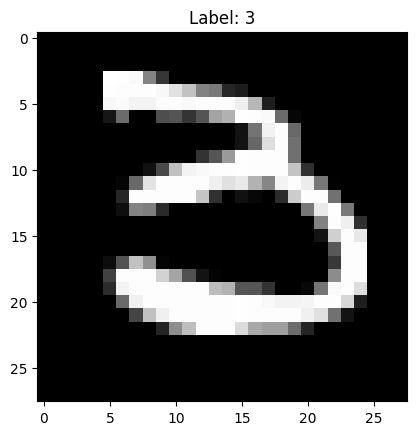

In [ ]:
# Take one batch of the dataset
for images, labels in ds_train.take(1):
    # Visualize the first image in the batch
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {labels[0].numpy()}")
    plt.show()


In [ ]:
ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(ds_info.splits['train'].num_examples)
ds_val = ds_val.batch(128)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

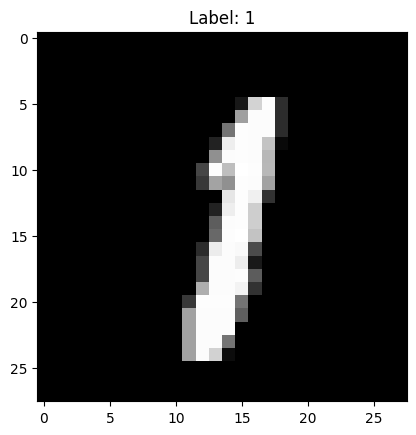

In [ ]:
# Take one batch of the dataset
for images, labels in ds_val.take(1):
    # Visualize the first image in the batch
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {labels[0].numpy()}")
    plt.show()

In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

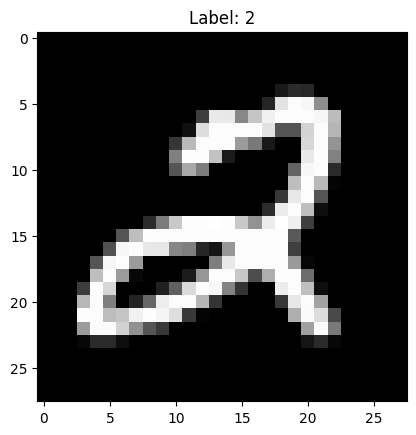

In [ ]:
# Take one batch of the dataset
for images, labels in ds_test.take(1):
    # Visualize the first image in the batch
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {labels[0].numpy()}")
    plt.show()

### Building the CNN

This section contains information about the seteps carried out to build the hyperparameter and analyse the parameter with the best validation and test accuracy.
The basic model consist of the input layer, convolution layer, fully connected Layers, and the output layers.

* Input Layer: this is the layers that is mapped to the input pixel of the image.
* Convolutional Layers: These layers extract features from input data through convolution operations.
* Fully Connected Layers: These layers process the extracted features from th convolution layer for classification or regression.
* Flattening Layer: Converts multidimensional feature maps into a one-dimensional vector for input into fully connected layers.
* Output Layer: Produces the final prediction or output of the network.
* Pooling Layers: These layers downsample feature maps, reducing computational complexity and preventing overfitting.
Other Keywords
* Activation Functions: They introduce non-linearities into the network to help it learn complex patterns.




##### Train CNN

In [ ]:
def train(train_dataset,validation_data, model, num_epoch=6):
  history = model.fit(
    train_dataset,
    epochs=num_epoch,
    validation_data=validation_data,
)

  return history

In [ ]:
test_result = pd.DataFrame(columns=['loss','accuracy', 'param'])

In [ ]:
def model_evaluate(model, history, param_desc, test_data =ds_test):
  # Evaluate the model
  global test_result
  test_loss, test_acc = model.evaluate(ds_test, verbose=2)
  print('\nTest accuracy:', test_acc, '\n')
  row = [test_loss, test_acc, param_desc]
  row_df = pd.DataFrame([row], columns=test_result.columns)
  test_result = pd.concat([test_result,row_df], ignore_index=True)
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  print("\n")
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  history_table =  pd.DataFrame(history.history)

  return history_table

In [ ]:
def visualize_result(test_result):
    """
    Plots a grouped bar chart with accuracies and losses as bars, parameters as labels,
    and displays the values on top of each bar.

    Args:
    - test_result (pd.DataFrame): DataFrame containing 'accuracy', 'loss', and 'param' columns.
    """
    # Setting the positions and width for the bars
    positions = np.arange(len(test_result))
    width = 0.4  # the width of the bars

    # Creating the figure and axes for the bar plots
    fig, ax = plt.subplots(figsize=(20, 10))
    bars_accuracy = ax.bar(positions - width/2, test_result['accuracy'], width, label='Accuracy', color='blue')
    bars_loss = ax.bar(positions + width/2, test_result['loss'], width, label='Loss', color='green')

    # Adding some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Values')
    ax.set_title('Model Performance by Parameter Configuration')
    ax.set_xticks(positions)
    ax.set_xticklabels(test_result['param'], rotation=90, ha="right")

    ax.legend()

    # Adding value labels on top of each bar
    ax.bar_label(bars_accuracy, padding=3, fmt='%.4f')
    ax.bar_label(bars_loss, padding=3, fmt='%.4f')

    # Show grid and make layout adjustments
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

#### 1. Build a CNN with at least one convolutional layer and 2 or more hidden layers and a dense output layer for 10 classes.

In the CNN defined below has, the number of layers for each component is defined as:  
* Convolution Layer: 2
* Fully connected Layer: 3
* and output Layer

The relu activation function was used for all the layers except the output layer.

The accuracy of the model on the test dataset was 0.9869 with a loss of 0.046394. The graph shows a possibility of overfitting at the 7th epoch.


In [ ]:
model = models.Sequential([
    #Input layer and first convolution
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2,strides=2),
    # second convolution Layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    # dense layer
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    #output layer
    layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
# using the train function to train the model
history = train(ds_train, ds_val,model,num_epoch=7)

Epoch 1/7
399/399 [==============================] - 43s 100ms/step - loss: 0.2776 - accuracy: 0.9151 - val_loss: 0.0934 - val_accuracy: 0.9712
Epoch 2/7
399/399 [==============================] - 39s 98ms/step - loss: 0.0718 - accuracy: 0.9781 - val_loss: 0.0503 - val_accuracy: 0.9850
Epoch 3/7
399/399 [==============================] - 42s 105ms/step - loss: 0.0509 - accuracy: 0.9844 - val_loss: 0.0439 - val_accuracy: 0.9854
Epoch 4/7
399/399 [==============================] - 38s 96ms/step - loss: 0.0368 - accuracy: 0.9884 - val_loss: 0.0363 - val_accuracy: 0.9894
Epoch 5/7
399/399 [==============================] - 37s 94ms/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.0191 - val_accuracy: 0.9947
Epoch 6/7
399/399 [==============================] - 40s 100ms/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0231 - val_accuracy: 0.9927
Epoch 7/7
399/399 [==============================] - 38s 96ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0200 - val_accuracy: 0.9

79/79 - 3s - loss: 0.0344 - accuracy: 0.9893 - 3s/epoch - 32ms/step

Test accuracy: 0.989300012588501 



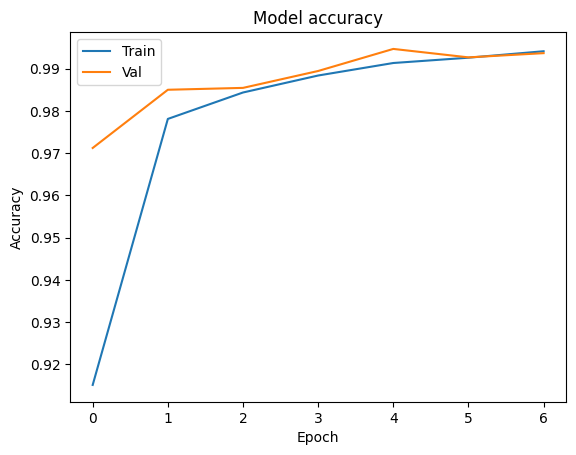

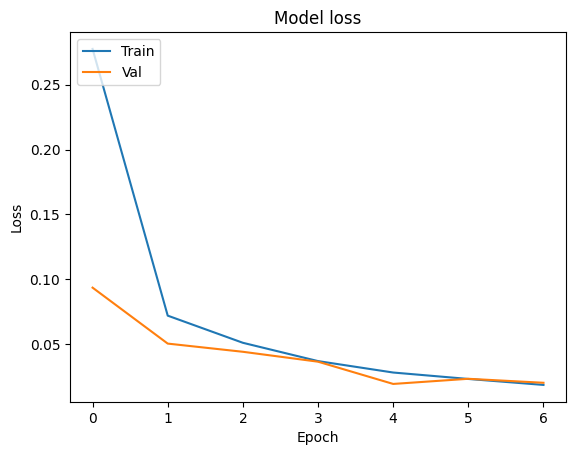

In [ ]:
history_table = model_evaluate(model, history,"ac_func: 'relu', optimizer: 'adam'" ,ds_test)

In [ ]:
test_result

,loss,accuracy,param
0,0.034437,0.9893,"ac_func: 'relu', optimizer: 'adam'"


#### 5a. Increase the size and depth of the inner layers, what is the effect on the model accuracy?

The size and depth of the previous model was increased by adding 2 additional FC layer and 1 convolutional Layer.

| Layer (type)           | Output Shape         | Param # |
|------------------------|----------------------|---------|
| conv2d_7 (Conv2D)      | (None, 26, 26, 32)   | 320     |
| max_pooling2d_6 (MaxPooling2D) | (None, 13, 13, 32)   | 0       |
| conv2d_8 (Conv2D)      | (None, 11, 11, 64)   | 18496   |
| max_pooling2d_7 (MaxPooling2D) | (None, 5, 5, 64)     | 0       |
| conv2d_9 (Conv2D)      | (None, 3, 3, 64)     | 36928   |
| flatten_3 (Flatten)    | (None, 576)          | 0       |
| dense_12 (Dense)       | (None, 256)          | 147712  |
| dense_13 (Dense)       | (None, 128)          | 32896   |
| dense_14 (Dense)       | (None, 128)          | 16512   |
| dense_15 (Dense)       | (None, 128)          | 16512   |
| dense_16 (Dense)       | (None, 128)          | 16512   |
| dense_17 (Dense)       | (None, 10)           | 1290    |
| **Total params:** 287,178 (1.10 MB) | | |
| **Trainable params:** 287,178 (1.10 MB) | | |
| **Non-trainable params:** 0 (0.00 Byte) | | |


 The increase in the size and shape of the network resulted in overfitting and a reduction in the accuracy of the model from 98.93% to 98.49%.

In [ ]:
model = models.Sequential([
    #first layer
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2,strides=2),
    # second convolution Layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # third convolution Layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 1, 64)         

In [ ]:
history = train(ds_train, ds_val,model,num_epoch=6)

Epoch 1/6
399/399 [==============================] - 44s 106ms/step - loss: 0.4149 - accuracy: 0.8655 - val_loss: 0.1973 - val_accuracy: 0.9381
Epoch 2/6
399/399 [==============================] - 42s 105ms/step - loss: 0.1075 - accuracy: 0.9668 - val_loss: 0.0630 - val_accuracy: 0.9827
Epoch 3/6
399/399 [==============================] - 41s 104ms/step - loss: 0.0731 - accuracy: 0.9782 - val_loss: 0.0579 - val_accuracy: 0.9828
Epoch 4/6
399/399 [==============================] - 42s 106ms/step - loss: 0.0592 - accuracy: 0.9815 - val_loss: 0.0703 - val_accuracy: 0.9790
Epoch 5/6
399/399 [==============================] - 41s 102ms/step - loss: 0.0540 - accuracy: 0.9840 - val_loss: 0.0378 - val_accuracy: 0.9881
Epoch 6/6
399/399 [==============================] - 42s 104ms/step - loss: 0.0418 - accuracy: 0.9872 - val_loss: 0.0311 - val_accuracy: 0.9897


79/79 - 2s - loss: 0.0507 - accuracy: 0.9849 - 2s/epoch - 24ms/step

Test accuracy: 0.9848999977111816 



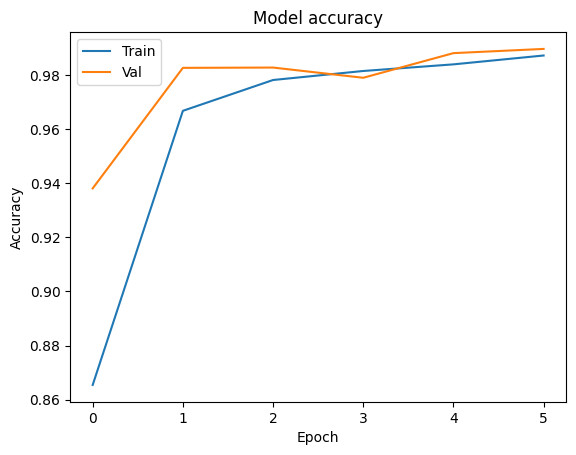

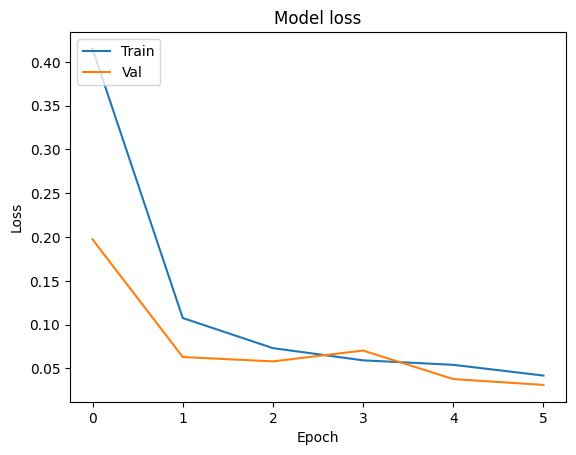

In [ ]:
history_table = model_evaluate(model, history,"ac_func: 'relu', optimizer: 'adam', added 2 FC", ds_test)

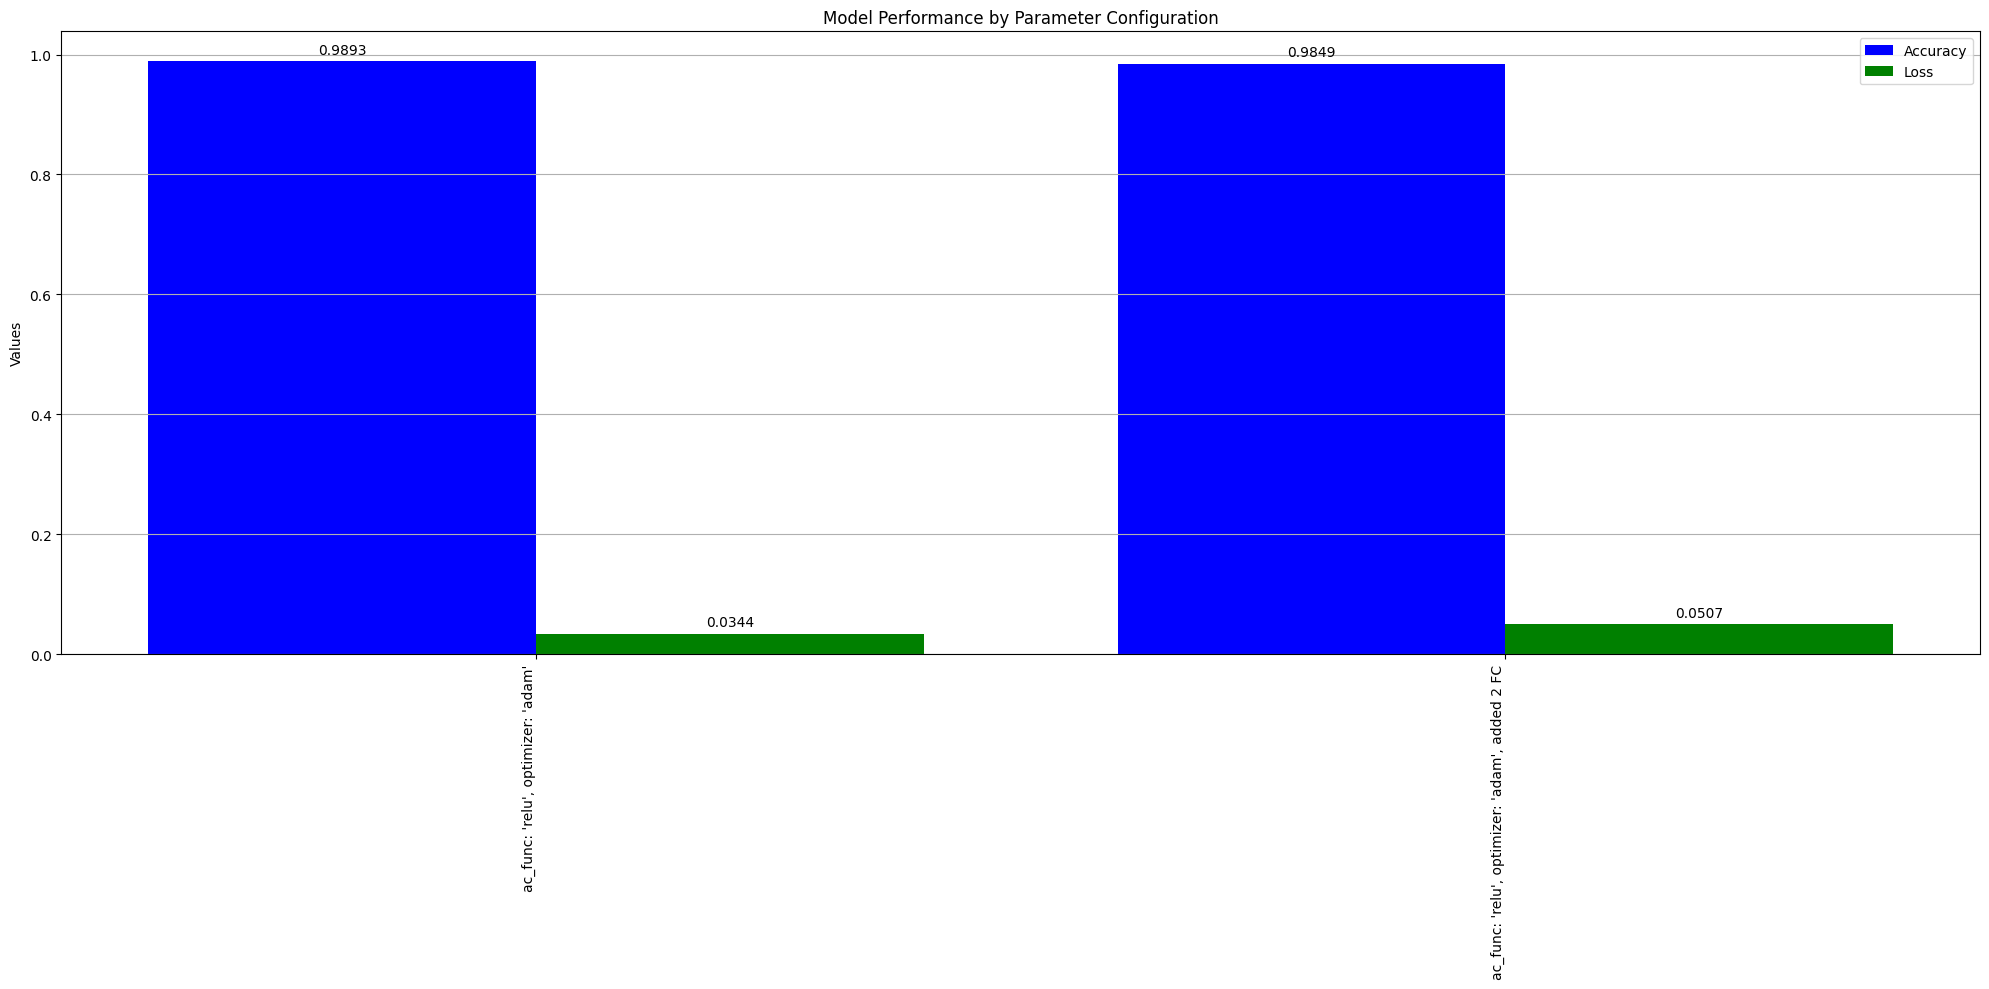

In [ ]:
visualize_result(test_result)

#### Experiment with different activation functions in the inner layers (relu, sigmoid, softmask, etc), see the list of keras activation functions at https://keras.io/api/layers/activations/

This section trains the first model using seven different activation function.
The activation function is a mathemathecal function that introduces non-linearity into the model. Different activation functionoperates introduces differnt type of non-linearity.

The activation functions used in this section are
1. **Sigmoid:**
   - The sigmoid function is a logistic function that outputs a value between 0 and 1. It's defined as: \(f(x) = frac{1}{1 + e^{-x}}\). This function was historically used for binary classification tasks within neural networks.

2. **Softplus:**
   - The softplus function is a smooth approximation of the ReLU function. It's defined as \(f(x) = ln(1 + e^{x})\). This function provides a smooth, differentiable transition from 0 to positive values, making it useful for deep learning models.

3. **Softsign:**
   - The softsign function is similar to the tanh function but uses a different normalization method. It's defined as \(f(x) = \frac{x}{1 + |x|}\). This function outputs values in the range (-1, 1) and provides a softer transition than tanh.

4. **Tanh:**
   - The hyperbolic tangent function, or tanh, outputs values between -1 and 1. It's defined as \(f(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}\). This function is zero-centered, making it preferred over the sigmoid in hidden layers of a neural network.

5. **SELU (Scaled Exponential Linear Unit):**
   - The SELU function is designed to make the mean and variance of the outputs of each layer in a neural network to remain more stable during training. It's defined as \(f(x) = \lambda \cdot \begin{cases} x & \text{if } x > 0 \\ \alpha \cdot (e^{x} - 1) & \text{if } x \leq 0 \end{cases}\), where \(\lambda\) and \(\alpha\) are predefined constants.

6. **ReLU6:**
   - The ReLU6 function is a variant of the ReLU function that caps the maximum output value at 6. It's defined as \(f(x) = \min(\max(0, x), 6)\). This function is used to prevent the activations from becoming too large and is particularly useful in models that are sensitive to the scale of activations, such as those using low-precision arithmetic.

7. **SiLU (Sigmoid Linear Unit, also known as Swish):**
   - The SiLU function is defined as \(f(x) = x \cdot \sigma(x)\), where \(\sigma(x)\) is the sigmoid function. This activation function has been shown to outperform ReLU in deeper networks, as it allows for both positive and negative values, providing a more dynamic range of activations.

The 6 optimizers were used to train a model with the datasets and then tested using the test datasets. The sigmoid function had the least accuracy and the highet loss. The relu, relu6 and tanh had a good performance and improved the accuracy score of the model by a few decimals.


In [ ]:
def make_model(activation):
  model = models.Sequential([
    #first layer
    layers.Conv2D(32, (3,3), activation=activation, input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2,strides=2),
    # second convolution Layer
    layers.Conv2D(64, (3,3), activation=activation),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation=activation),
    layers.Dense(64, activation=activation),
    layers.Dense(64, activation=activation),

    layers.Dense(10, activation='softmax')
])

  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )
  return model


The activation function is: sigmoid

Epoch 1/6
399/399 [==============================] - 44s 106ms/step - loss: 2.3067 - accuracy: 0.1067 - val_loss: 2.3031 - val_accuracy: 0.1157
Epoch 2/6
399/399 [==============================] - 42s 106ms/step - loss: 2.3043 - accuracy: 0.1074 - val_loss: 2.3031 - val_accuracy: 0.1157
Epoch 3/6
399/399 [==============================] - 42s 105ms/step - loss: 2.3043 - accuracy: 0.1085 - val_loss: 2.3022 - val_accuracy: 0.0970
Epoch 4/6
399/399 [==============================] - 42s 105ms/step - loss: 2.3036 - accuracy: 0.1087 - val_loss: 2.3040 - val_accuracy: 0.1072
Epoch 5/6
399/399 [==============================] - 42s 105ms/step - loss: 2.3034 - accuracy: 0.1093 - val_loss: 2.3038 - val_accuracy: 0.1072
Epoch 6/6
399/399 [==============================] - 41s 103ms/step - loss: 1.5815 - accuracy: 0.4551 - val_loss: 0.3116 - val_accuracy: 0.9324
79/79 - 2s - loss: 0.3118 - accuracy: 0.9306 - 2s/epoch - 24ms/step

Test accuracy: 0.930599987506

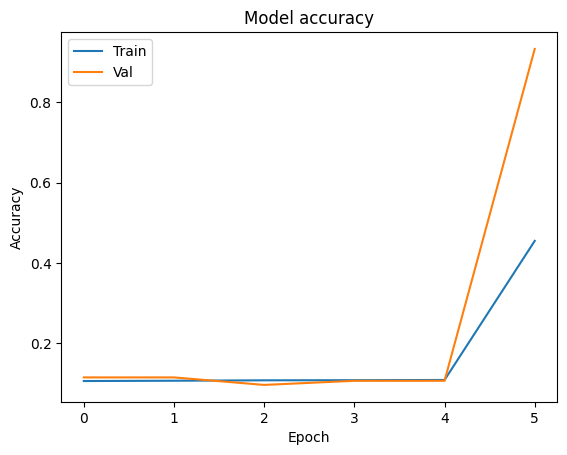

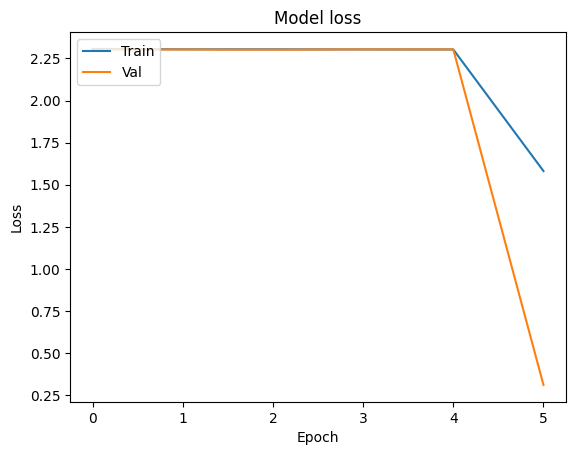


The activation function is: softplus

Epoch 1/6
399/399 [==============================] - 54s 132ms/step - loss: 0.9845 - accuracy: 0.6442 - val_loss: 0.1503 - val_accuracy: 0.9546
Epoch 2/6
399/399 [==============================] - 52s 131ms/step - loss: 0.1294 - accuracy: 0.9597 - val_loss: 0.1003 - val_accuracy: 0.9690
Epoch 3/6
399/399 [==============================] - 52s 131ms/step - loss: 0.0845 - accuracy: 0.9741 - val_loss: 0.0569 - val_accuracy: 0.9828
Epoch 4/6
399/399 [==============================] - 52s 130ms/step - loss: 0.0646 - accuracy: 0.9798 - val_loss: 0.0476 - val_accuracy: 0.9848
Epoch 5/6
399/399 [==============================] - 54s 134ms/step - loss: 0.0549 - accuracy: 0.9827 - val_loss: 0.0387 - val_accuracy: 0.9884
Epoch 6/6
399/399 [==============================] - 53s 133ms/step - loss: 0.0444 - accuracy: 0.9861 - val_loss: 0.0344 - val_accuracy: 0.9896
79/79 - 2s - loss: 0.0464 - accuracy: 0.9866 - 2s/epoch - 28ms/step

Test accuracy: 0.98659998178

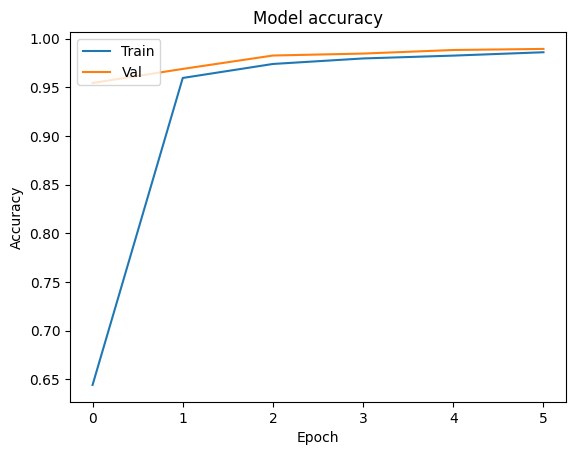

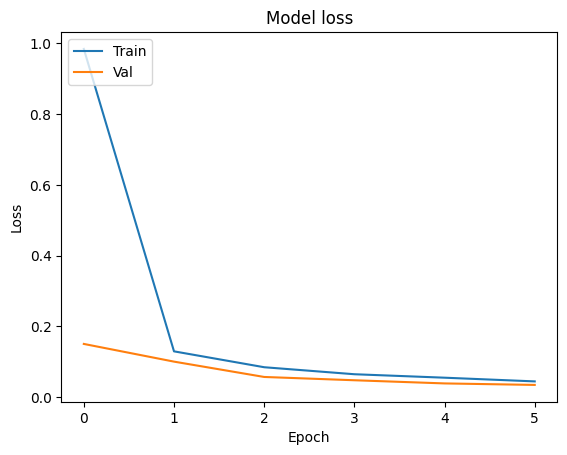


The activation function is: relu

Epoch 1/6
399/399 [==============================] - 41s 99ms/step - loss: 0.2617 - accuracy: 0.9182 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 2/6
399/399 [==============================] - 40s 99ms/step - loss: 0.0652 - accuracy: 0.9797 - val_loss: 0.0415 - val_accuracy: 0.9874
Epoch 3/6
399/399 [==============================] - 40s 99ms/step - loss: 0.0459 - accuracy: 0.9860 - val_loss: 0.0333 - val_accuracy: 0.9890
Epoch 4/6
399/399 [==============================] - 40s 99ms/step - loss: 0.0345 - accuracy: 0.9896 - val_loss: 0.0310 - val_accuracy: 0.9904
Epoch 5/6
399/399 [==============================] - 39s 98ms/step - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0208 - val_accuracy: 0.9931
Epoch 6/6
399/399 [==============================] - 39s 97ms/step - loss: 0.0214 - accuracy: 0.9932 - val_loss: 0.0284 - val_accuracy: 0.9914
79/79 - 2s - loss: 0.0433 - accuracy: 0.9858 - 2s/epoch - 22ms/step

Test accuracy: 0.98580002784729 



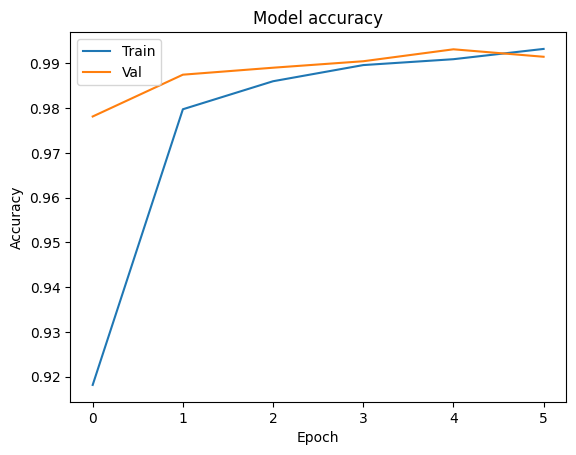

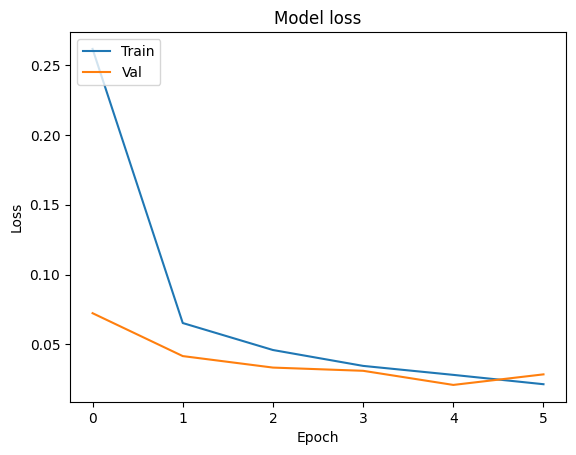


The activation function is: tanh

Epoch 1/6
399/399 [==============================] - 44s 106ms/step - loss: 0.2144 - accuracy: 0.9407 - val_loss: 0.0544 - val_accuracy: 0.9843
Epoch 2/6
399/399 [==============================] - 43s 108ms/step - loss: 0.0549 - accuracy: 0.9837 - val_loss: 0.0420 - val_accuracy: 0.9873
Epoch 3/6
399/399 [==============================] - 43s 108ms/step - loss: 0.0361 - accuracy: 0.9892 - val_loss: 0.0289 - val_accuracy: 0.9916
Epoch 4/6
399/399 [==============================] - 42s 106ms/step - loss: 0.0251 - accuracy: 0.9927 - val_loss: 0.0288 - val_accuracy: 0.9908
Epoch 5/6
399/399 [==============================] - 43s 107ms/step - loss: 0.0203 - accuracy: 0.9937 - val_loss: 0.0188 - val_accuracy: 0.9947
Epoch 6/6
399/399 [==============================] - 43s 107ms/step - loss: 0.0152 - accuracy: 0.9954 - val_loss: 0.0189 - val_accuracy: 0.9936
79/79 - 2s - loss: 0.0377 - accuracy: 0.9892 - 2s/epoch - 23ms/step

Test accuracy: 0.989199995994567

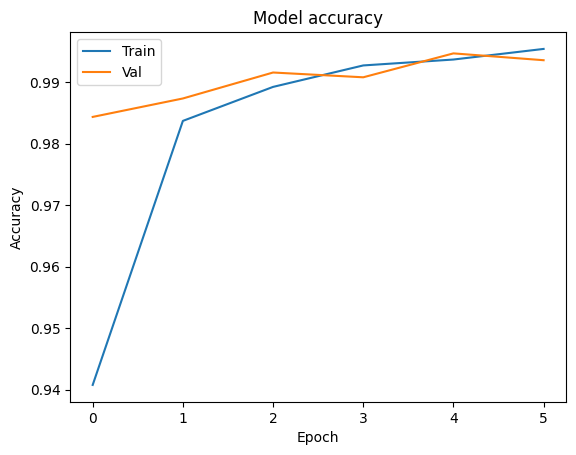

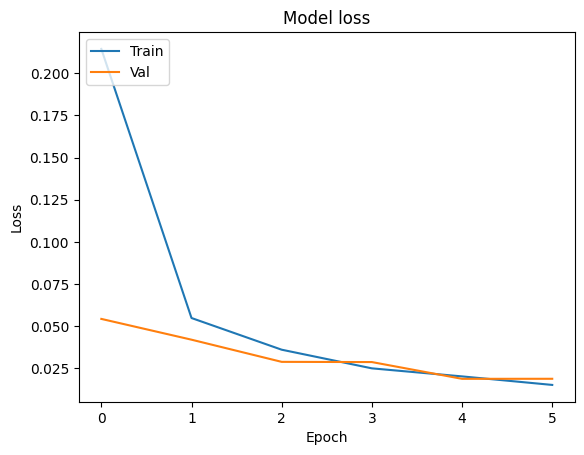


The activation function is: selu

Epoch 1/6
399/399 [==============================] - 45s 111ms/step - loss: 0.1880 - accuracy: 0.9434 - val_loss: 0.0705 - val_accuracy: 0.9784
Epoch 2/6
399/399 [==============================] - 45s 112ms/step - loss: 0.0593 - accuracy: 0.9811 - val_loss: 0.0424 - val_accuracy: 0.9880
Epoch 3/6
399/399 [==============================] - 46s 114ms/step - loss: 0.0433 - accuracy: 0.9865 - val_loss: 0.0325 - val_accuracy: 0.9884
Epoch 4/6
399/399 [==============================] - 45s 112ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0253 - val_accuracy: 0.9917
Epoch 5/6
399/399 [==============================] - 44s 111ms/step - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.0273 - val_accuracy: 0.9912
Epoch 6/6
399/399 [==============================] - 45s 112ms/step - loss: 0.0203 - accuracy: 0.9932 - val_loss: 0.0198 - val_accuracy: 0.9931
79/79 - 2s - loss: 0.0471 - accuracy: 0.9859 - 2s/epoch - 24ms/step

Test accuracy: 0.985899984836578

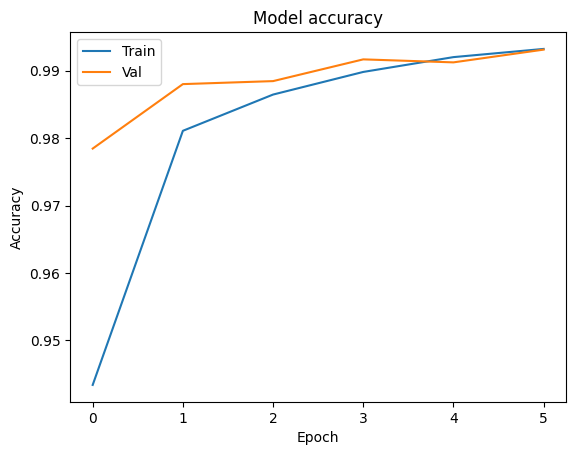

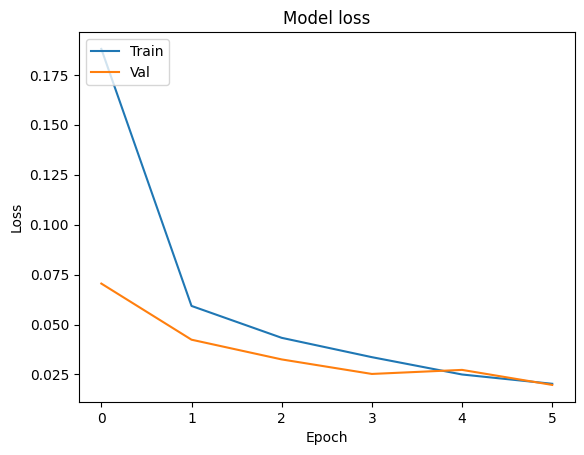


The activation function is: relu6

Epoch 1/6
399/399 [==============================] - 43s 103ms/step - loss: 0.2500 - accuracy: 0.9217 - val_loss: 0.0699 - val_accuracy: 0.9782
Epoch 2/6
399/399 [==============================] - 40s 100ms/step - loss: 0.0618 - accuracy: 0.9803 - val_loss: 0.0504 - val_accuracy: 0.9836
Epoch 3/6
399/399 [==============================] - 41s 102ms/step - loss: 0.0435 - accuracy: 0.9864 - val_loss: 0.0303 - val_accuracy: 0.9907
Epoch 4/6
399/399 [==============================] - 40s 100ms/step - loss: 0.0357 - accuracy: 0.9888 - val_loss: 0.0381 - val_accuracy: 0.9873
Epoch 5/6
399/399 [==============================] - 39s 98ms/step - loss: 0.0276 - accuracy: 0.9914 - val_loss: 0.0187 - val_accuracy: 0.9947
Epoch 6/6
399/399 [==============================] - 40s 100ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0180 - val_accuracy: 0.9949
79/79 - 2s - loss: 0.0367 - accuracy: 0.9882 - 2s/epoch - 23ms/step

Test accuracy: 0.988200008869171

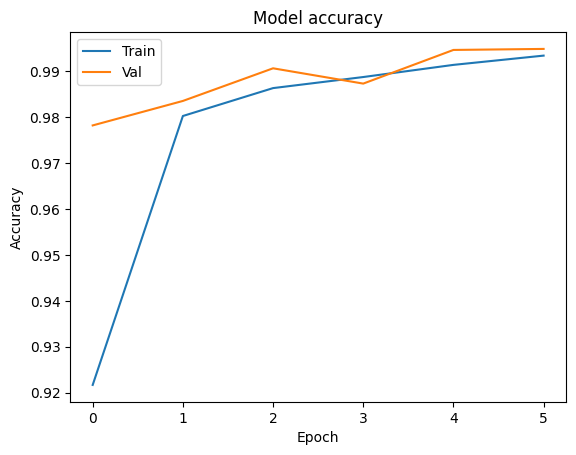

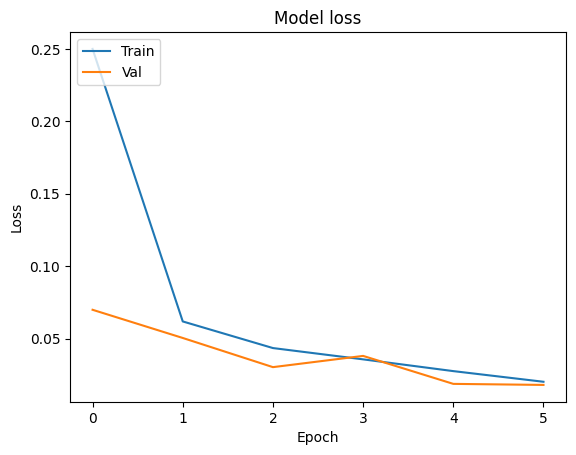


The activation function is: silu

Epoch 1/6
399/399 [==============================] - 56s 138ms/step - loss: 0.2899 - accuracy: 0.9101 - val_loss: 0.0785 - val_accuracy: 0.9754
Epoch 2/6
399/399 [==============================] - 56s 141ms/step - loss: 0.0704 - accuracy: 0.9777 - val_loss: 0.0427 - val_accuracy: 0.9873
Epoch 3/6
399/399 [==============================] - 54s 135ms/step - loss: 0.0440 - accuracy: 0.9866 - val_loss: 0.0330 - val_accuracy: 0.9907
Epoch 4/6
399/399 [==============================] - 57s 142ms/step - loss: 0.0343 - accuracy: 0.9892 - val_loss: 0.0258 - val_accuracy: 0.9922
Epoch 5/6
399/399 [==============================] - 54s 136ms/step - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.0153 - val_accuracy: 0.9954
Epoch 6/6
399/399 [==============================] - 54s 134ms/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.0263 - val_accuracy: 0.9918
79/79 - 2s - loss: 0.0488 - accuracy: 0.9851 - 2s/epoch - 31ms/step

Test accuracy: 0.985099971294403

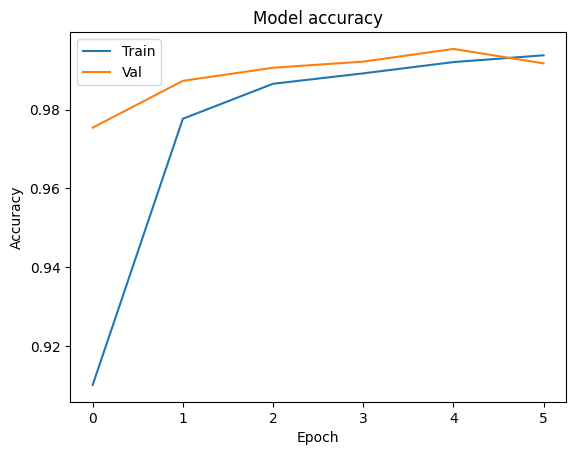

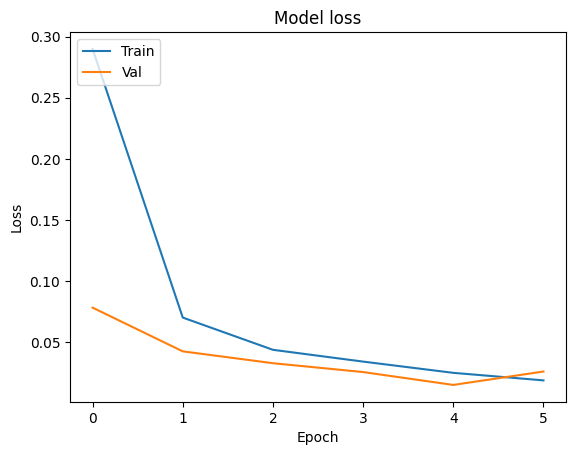

In [ ]:
activations = ['sigmoid', 'softplus', 'relu', 'tanh', 'selu','relu6','silu']
history_tables = pd.DataFrame()

for ac in activations:
  print(f"\nThe activation function is: {ac}\n")
  model = make_model(ac)
  history = train(ds_train, ds_val,model,num_epoch=6)
  params_desc =f"ac_tuning: activation:{ac}, optimizer:'adam'"
  history_table = model_evaluate(model, history,params_desc,  ds_test)
  history_table['activation_function'] = ac
  history_tables =pd.concat([history_tables, history_table], ignore_index=True, axis=0)


In [ ]:
history_tables

,loss,accuracy,val_loss,val_accuracy,activation_function
0,2.306682,0.106667,2.303057,0.115667,sigmoid
1,2.304281,0.107431,2.303088,0.115667,sigmoid
2,2.304322,0.108451,2.302219,0.097000,sigmoid
3,2.303563,0.108745,2.303964,0.107222,sigmoid
4,2.303439,0.109314,2.303816,0.107222,sigmoid
5,1.581511,0.455118,0.311639,0.932444,sigmoid
6,0.984463,0.644216,0.150337,0.954556,softplus
7,0.129365,0.959706,0.100295,0.969000,softplus
8,0.084453,0.974098,0.056929,0.982778,softplus
9,0.064650,0.979765,0.047624,0.984778,softplus


In [ ]:
history_tables.to_csv("activation_function_evaluation.csv")

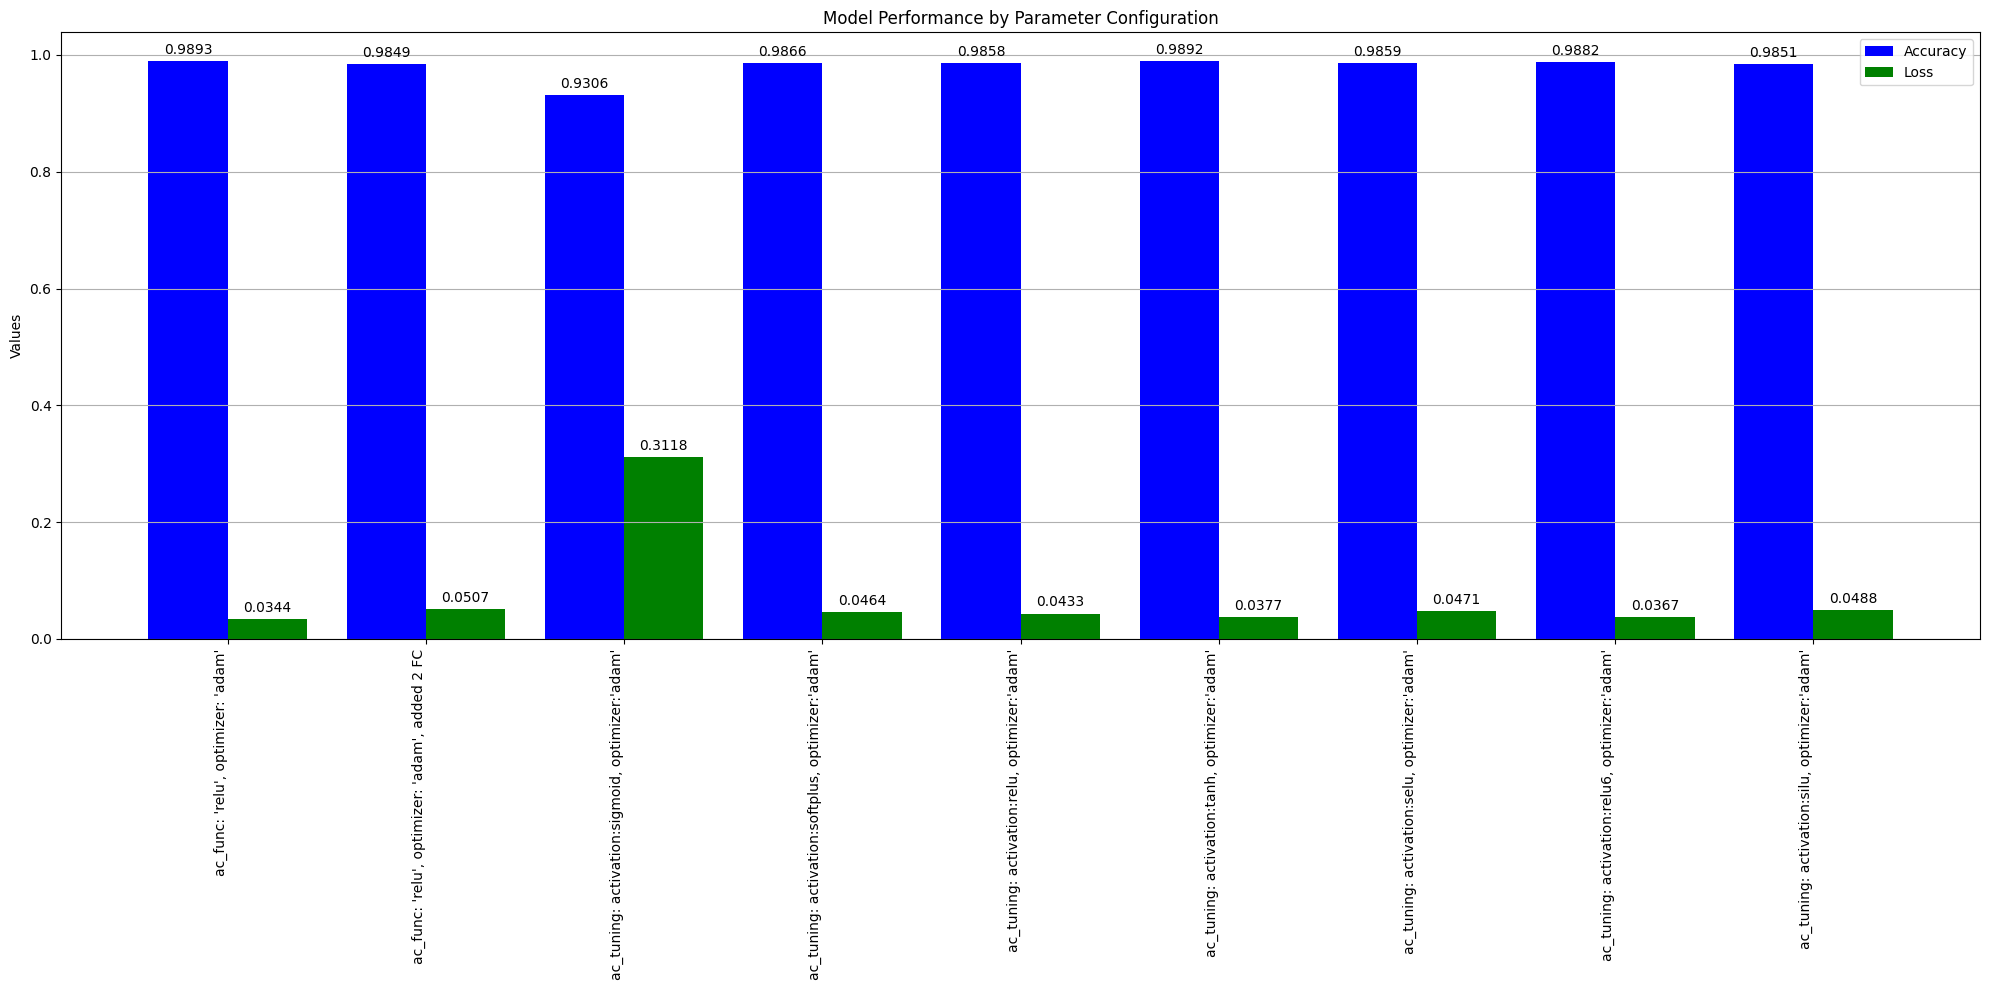

In [ ]:
visualize_result(test_result)

#### Combining the activation function choice with different network size and depth.

The make_model function elow dynamically creates a model and compiles it based on the number of layers and units predefined when the model is called. This parameters are then tested on two activation function (relu and relu6). The tanh was not used in this step because it the performance during training was not as steady as relu and relu6. Unlike the later two tanh shows sign of overfitting with additional epochs.

The relu6 algorithm with 3 layers convolution layers of 32,128,128 output units and 3 fully connected layers with output 384,256,128. the accuracy of this combination was 99.11%.

The seond best was the relu activation function combined with similar layer combination.

In [ ]:
def make_model(activation, num_layers=3, units_per_layer=64):
    model = models.Sequential()
    # Input layer
    layers.Conv2D(32, (3,3), activation=activation, input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2,strides=2),
    # Variable intermediate layers based on num_layers and units_per_layer
    for i in range(num_layers-1):  # Subtracting 1 because the first conv layer is already defined
        model.add(layers.Conv2D(units_per_layer, (3, 3), activation=activation))
        model.add(layers.MaxPooling2D((2, 2)))

    # Flattening before passing to the dense layers
    model.add(layers.Flatten())

    # Add dense layers for depth
    for i in range(num_layers):

        model.add(layers.Dense(units_per_layer* np.abs(i - num_layers), activation=activation))

    # Output layer
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
activations = ['relu', 'relu6']
network_configs = [(2, 64), (3, 128), (3, 64), (2, 128)]  # (num_,layers, units_per_layer)


Epoch 1/6
399/399 [==============================] - 42s 103ms/step - loss: 0.2268 - accuracy: 0.9336 - val_loss: 0.0720 - val_accuracy: 0.9783
Epoch 2/6
399/399 [==============================] - 42s 104ms/step - loss: 0.0631 - accuracy: 0.9813 - val_loss: 0.0444 - val_accuracy: 0.9862
Epoch 3/6
399/399 [==============================] - 42s 104ms/step - loss: 0.0429 - accuracy: 0.9868 - val_loss: 0.0324 - val_accuracy: 0.9896
Epoch 4/6
399/399 [==============================] - 42s 104ms/step - loss: 0.0290 - accuracy: 0.9912 - val_loss: 0.0268 - val_accuracy: 0.9919
Epoch 5/6
399/399 [==============================] - 42s 104ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0169 - val_accuracy: 0.9953
Epoch 6/6
399/399 [==============================] - 41s 102ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0186 - val_accuracy: 0.9948
Activation: relu, Layers: 2, Units per Layer: 64
79/79 - 2s - loss: 0.0475 - accuracy: 0.9851 - 2s/epoch - 21ms/step

Test accuracy: 0.9

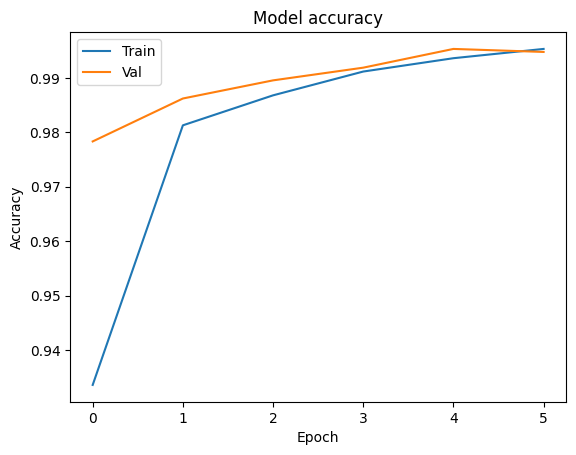

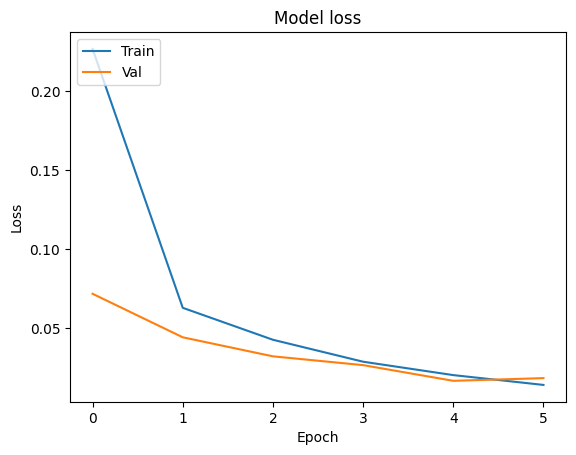

Epoch 1/6
399/399 [==============================] - 205s 510ms/step - loss: 0.1823 - accuracy: 0.9425 - val_loss: 0.0464 - val_accuracy: 0.9842
Epoch 2/6
399/399 [==============================] - 204s 510ms/step - loss: 0.0475 - accuracy: 0.9846 - val_loss: 0.0252 - val_accuracy: 0.9910
Epoch 3/6
399/399 [==============================] - 203s 508ms/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.0460 - val_accuracy: 0.9860
Epoch 4/6
399/399 [==============================] - 202s 507ms/step - loss: 0.0218 - accuracy: 0.9931 - val_loss: 0.0292 - val_accuracy: 0.9901
Epoch 5/6
399/399 [==============================] - 203s 509ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.0183 - val_accuracy: 0.9952
Epoch 6/6
399/399 [==============================] - 200s 501ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0161 - val_accuracy: 0.9949
Activation: relu, Layers: 3, Units per Layer: 128
79/79 - 11s - loss: 0.0284 - accuracy: 0.9909 - 11s/epoch - 135ms/step

Test acc

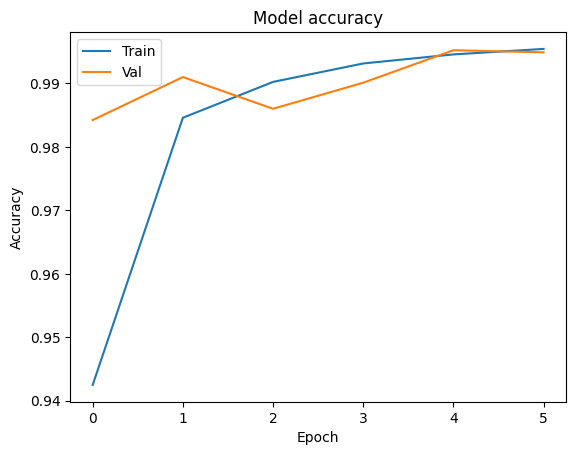

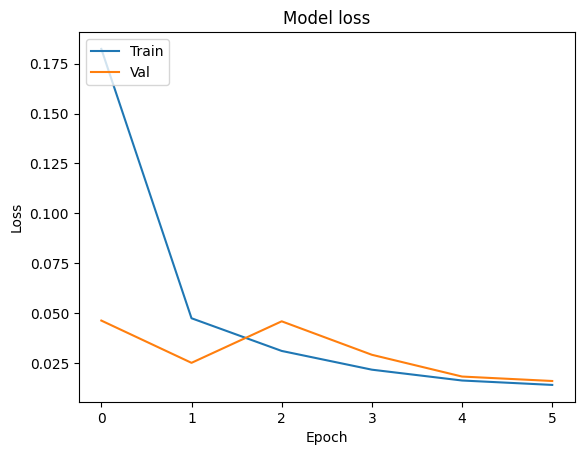

Epoch 1/6
399/399 [==============================] - 70s 172ms/step - loss: 0.2189 - accuracy: 0.9327 - val_loss: 0.0683 - val_accuracy: 0.9789
Epoch 2/6
399/399 [==============================] - 68s 171ms/step - loss: 0.0538 - accuracy: 0.9833 - val_loss: 0.0416 - val_accuracy: 0.9859
Epoch 3/6
399/399 [==============================] - 69s 172ms/step - loss: 0.0365 - accuracy: 0.9883 - val_loss: 0.0323 - val_accuracy: 0.9896
Epoch 4/6
399/399 [==============================] - 77s 193ms/step - loss: 0.0289 - accuracy: 0.9906 - val_loss: 0.0215 - val_accuracy: 0.9932
Epoch 5/6
399/399 [==============================] - 72s 180ms/step - loss: 0.0236 - accuracy: 0.9925 - val_loss: 0.0168 - val_accuracy: 0.9959
Epoch 6/6
399/399 [==============================] - 67s 167ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.0120 - val_accuracy: 0.9961
Activation: relu, Layers: 3, Units per Layer: 64
79/79 - 4s - loss: 0.0318 - accuracy: 0.9910 - 4s/epoch - 51ms/step

Test accuracy: 0.9

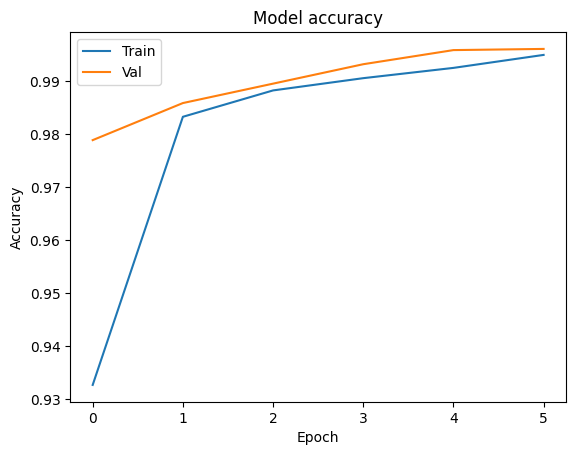

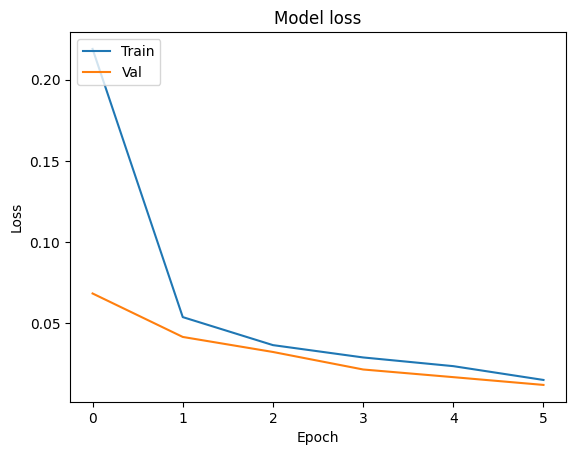

Epoch 1/6
399/399 [==============================] - 148s 367ms/step - loss: 0.1834 - accuracy: 0.9457 - val_loss: 0.0551 - val_accuracy: 0.9837
Epoch 2/6
399/399 [==============================] - 137s 342ms/step - loss: 0.0519 - accuracy: 0.9844 - val_loss: 0.0374 - val_accuracy: 0.9883
Epoch 3/6
399/399 [==============================] - 147s 367ms/step - loss: 0.0314 - accuracy: 0.9901 - val_loss: 0.0257 - val_accuracy: 0.9924
Epoch 4/6
399/399 [==============================] - 124s 309ms/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 0.0186 - val_accuracy: 0.9946
Epoch 5/6
399/399 [==============================] - 122s 307ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 0.0137 - val_accuracy: 0.9961
Epoch 6/6
399/399 [==============================] - 124s 312ms/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0169 - val_accuracy: 0.9954
Activation: relu, Layers: 2, Units per Layer: 128
79/79 - 5s - loss: 0.0508 - accuracy: 0.9855 - 5s/epoch - 68ms/step

Test accura

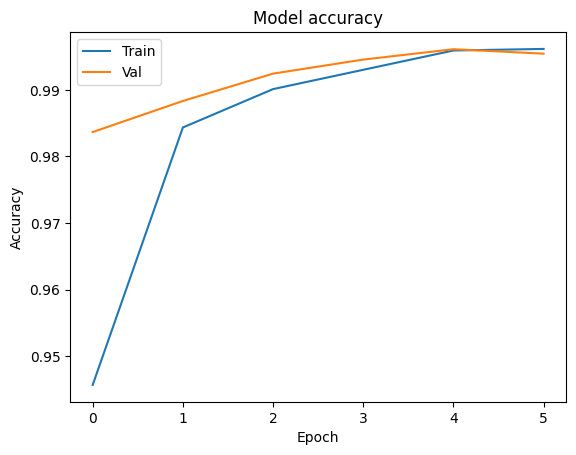

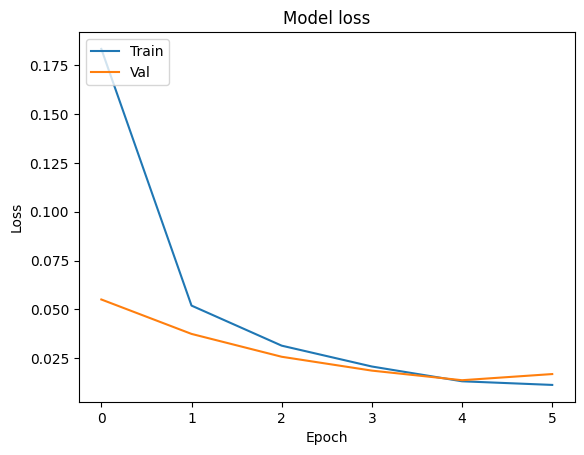

Epoch 1/6
399/399 [==============================] - 43s 104ms/step - loss: 0.2255 - accuracy: 0.9329 - val_loss: 0.0749 - val_accuracy: 0.9797
Epoch 2/6
399/399 [==============================] - 41s 104ms/step - loss: 0.0646 - accuracy: 0.9805 - val_loss: 0.0493 - val_accuracy: 0.9864
Epoch 3/6
399/399 [==============================] - 40s 101ms/step - loss: 0.0414 - accuracy: 0.9873 - val_loss: 0.0323 - val_accuracy: 0.9899
Epoch 4/6
399/399 [==============================] - 40s 101ms/step - loss: 0.0283 - accuracy: 0.9916 - val_loss: 0.0316 - val_accuracy: 0.9902
Epoch 5/6
399/399 [==============================] - 41s 102ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.0185 - val_accuracy: 0.9952
Epoch 6/6
399/399 [==============================] - 41s 102ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.0170 - val_accuracy: 0.9947
Activation: relu6, Layers: 2, Units per Layer: 64
79/79 - 2s - loss: 0.0445 - accuracy: 0.9849 - 2s/epoch - 21ms/step

Test accuracy: 0.

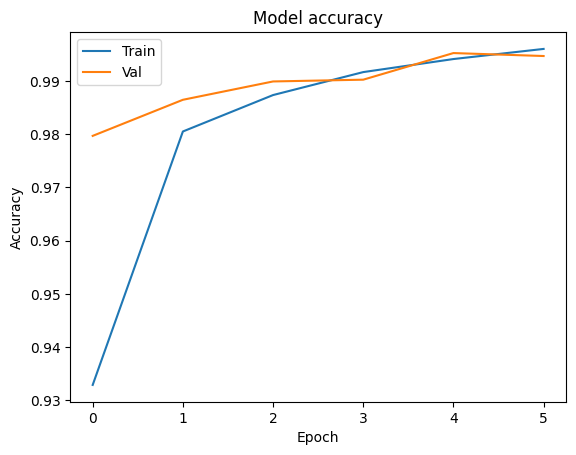

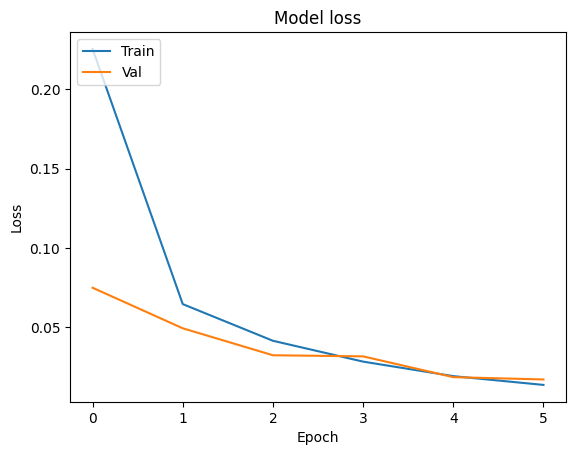

Epoch 1/6
399/399 [==============================] - 205s 510ms/step - loss: 0.1828 - accuracy: 0.9424 - val_loss: 0.0534 - val_accuracy: 0.9847
Epoch 2/6
399/399 [==============================] - 200s 502ms/step - loss: 0.0476 - accuracy: 0.9843 - val_loss: 0.0300 - val_accuracy: 0.9900
Epoch 3/6
399/399 [==============================] - 202s 506ms/step - loss: 0.0300 - accuracy: 0.9905 - val_loss: 0.0308 - val_accuracy: 0.9903
Epoch 4/6
399/399 [==============================] - 202s 505ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.0209 - val_accuracy: 0.9927
Epoch 5/6
399/399 [==============================] - 201s 505ms/step - loss: 0.0183 - accuracy: 0.9943 - val_loss: 0.0188 - val_accuracy: 0.9941
Epoch 6/6
399/399 [==============================] - 199s 500ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.0142 - val_accuracy: 0.9959
Activation: relu6, Layers: 3, Units per Layer: 128
79/79 - 11s - loss: 0.0313 - accuracy: 0.9911 - 11s/epoch - 135ms/step

Test ac

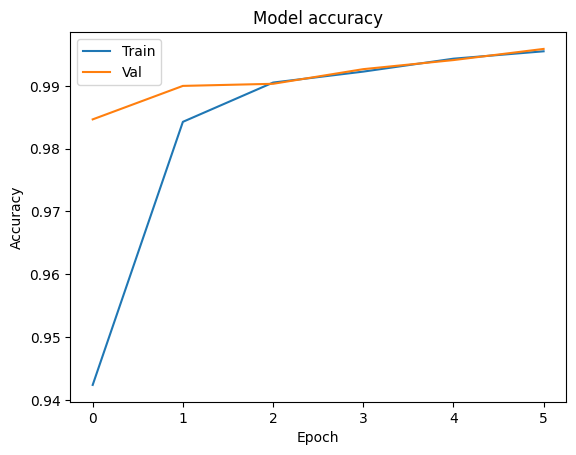

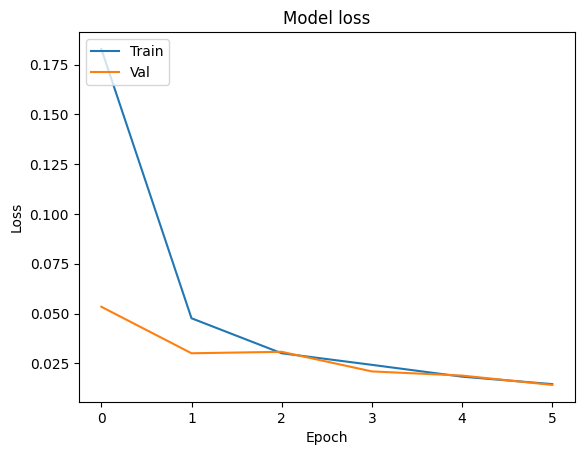

Epoch 1/6
399/399 [==============================] - 70s 172ms/step - loss: 0.2318 - accuracy: 0.9302 - val_loss: 0.0632 - val_accuracy: 0.9803
Epoch 2/6
399/399 [==============================] - 68s 171ms/step - loss: 0.0569 - accuracy: 0.9820 - val_loss: 0.0472 - val_accuracy: 0.9843
Epoch 3/6
399/399 [==============================] - 66s 165ms/step - loss: 0.0361 - accuracy: 0.9888 - val_loss: 0.0289 - val_accuracy: 0.9904
Epoch 4/6
399/399 [==============================] - 69s 172ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 0.0227 - val_accuracy: 0.9928
Epoch 5/6
399/399 [==============================] - 68s 170ms/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.0163 - val_accuracy: 0.9951
Epoch 6/6
399/399 [==============================] - 68s 171ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.0195 - val_accuracy: 0.9934
Activation: relu6, Layers: 3, Units per Layer: 64
79/79 - 4s - loss: 0.0376 - accuracy: 0.9871 - 4s/epoch - 50ms/step

Test accuracy: 0.

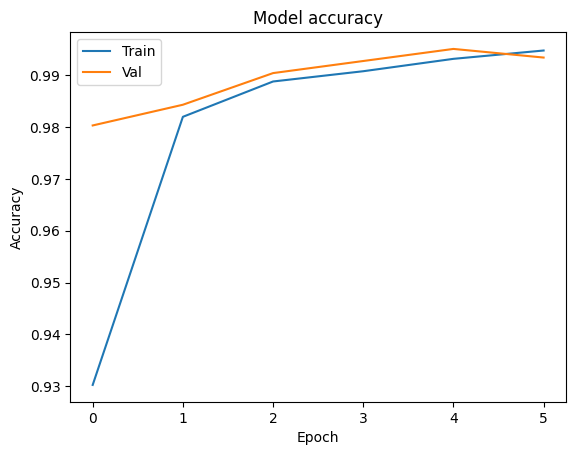

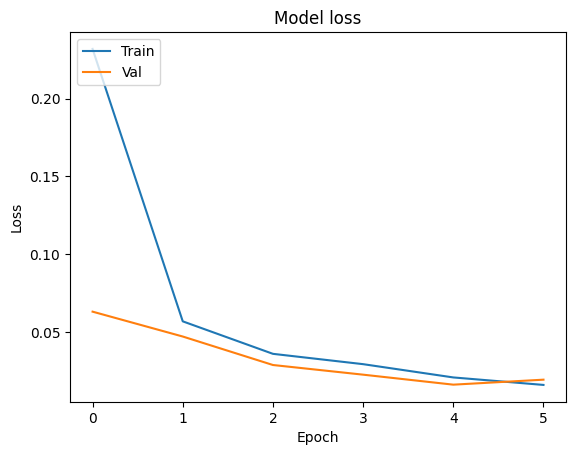

Epoch 1/6
399/399 [==============================] - 125s 310ms/step - loss: 0.1804 - accuracy: 0.9468 - val_loss: 0.0526 - val_accuracy: 0.9847
Epoch 2/6
399/399 [==============================] - 122s 305ms/step - loss: 0.0526 - accuracy: 0.9835 - val_loss: 0.0434 - val_accuracy: 0.9868
Epoch 3/6
399/399 [==============================] - 123s 307ms/step - loss: 0.0312 - accuracy: 0.9904 - val_loss: 0.0293 - val_accuracy: 0.9913
Epoch 4/6
399/399 [==============================] - 122s 305ms/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.0166 - val_accuracy: 0.9954
Epoch 5/6
399/399 [==============================] - 127s 319ms/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.0149 - val_accuracy: 0.9956
Epoch 6/6
399/399 [==============================] - 122s 307ms/step - loss: 0.0078 - accuracy: 0.9977 - val_loss: 0.0124 - val_accuracy: 0.9971
Activation: relu6, Layers: 2, Units per Layer: 128
79/79 - 6s - loss: 0.0445 - accuracy: 0.9869 - 6s/epoch - 82ms/step

Test accur

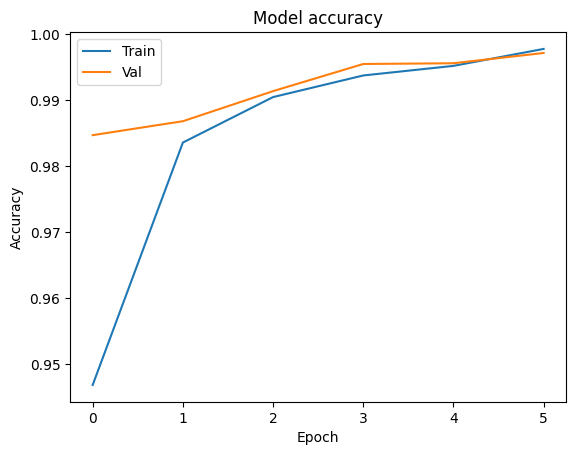

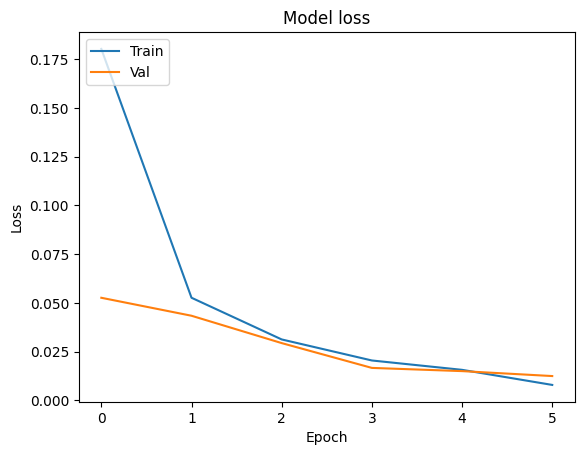

In [ ]:
history_tables = pd.DataFrame()

for activation in activations:
    for config in network_configs:
        num_layers, units_per_layer = config
        model = make_model(activation, num_layers, units_per_layer)

        # Assuming 'train' function exists and 'ds_train', 'ds_val' are your datasets
        history = train(ds_train, ds_val, model, num_epoch=6)
        print(f"Activation: {activation}, Layers: {num_layers}, Units per Layer: {units_per_layer}")
        params_desc= f"size_depth: actication:{activation}, (num, units): ({config})"

        # Assuming 'model_evaluate' function exists and returns a DataFrame or similar structure
        history_table = model_evaluate(model, history, params_desc, ds_test)
        history_table['activation_function'] = activation
        history_table['num_layers'] = num_layers
        history_table['units_per_layer'] = units_per_layer

        # Concatenating the new results
        history_tables = pd.concat([history_tables, history_table], ignore_index=True)

# save final results
history_tables.to_csv("network_depth_evaluation.csv")

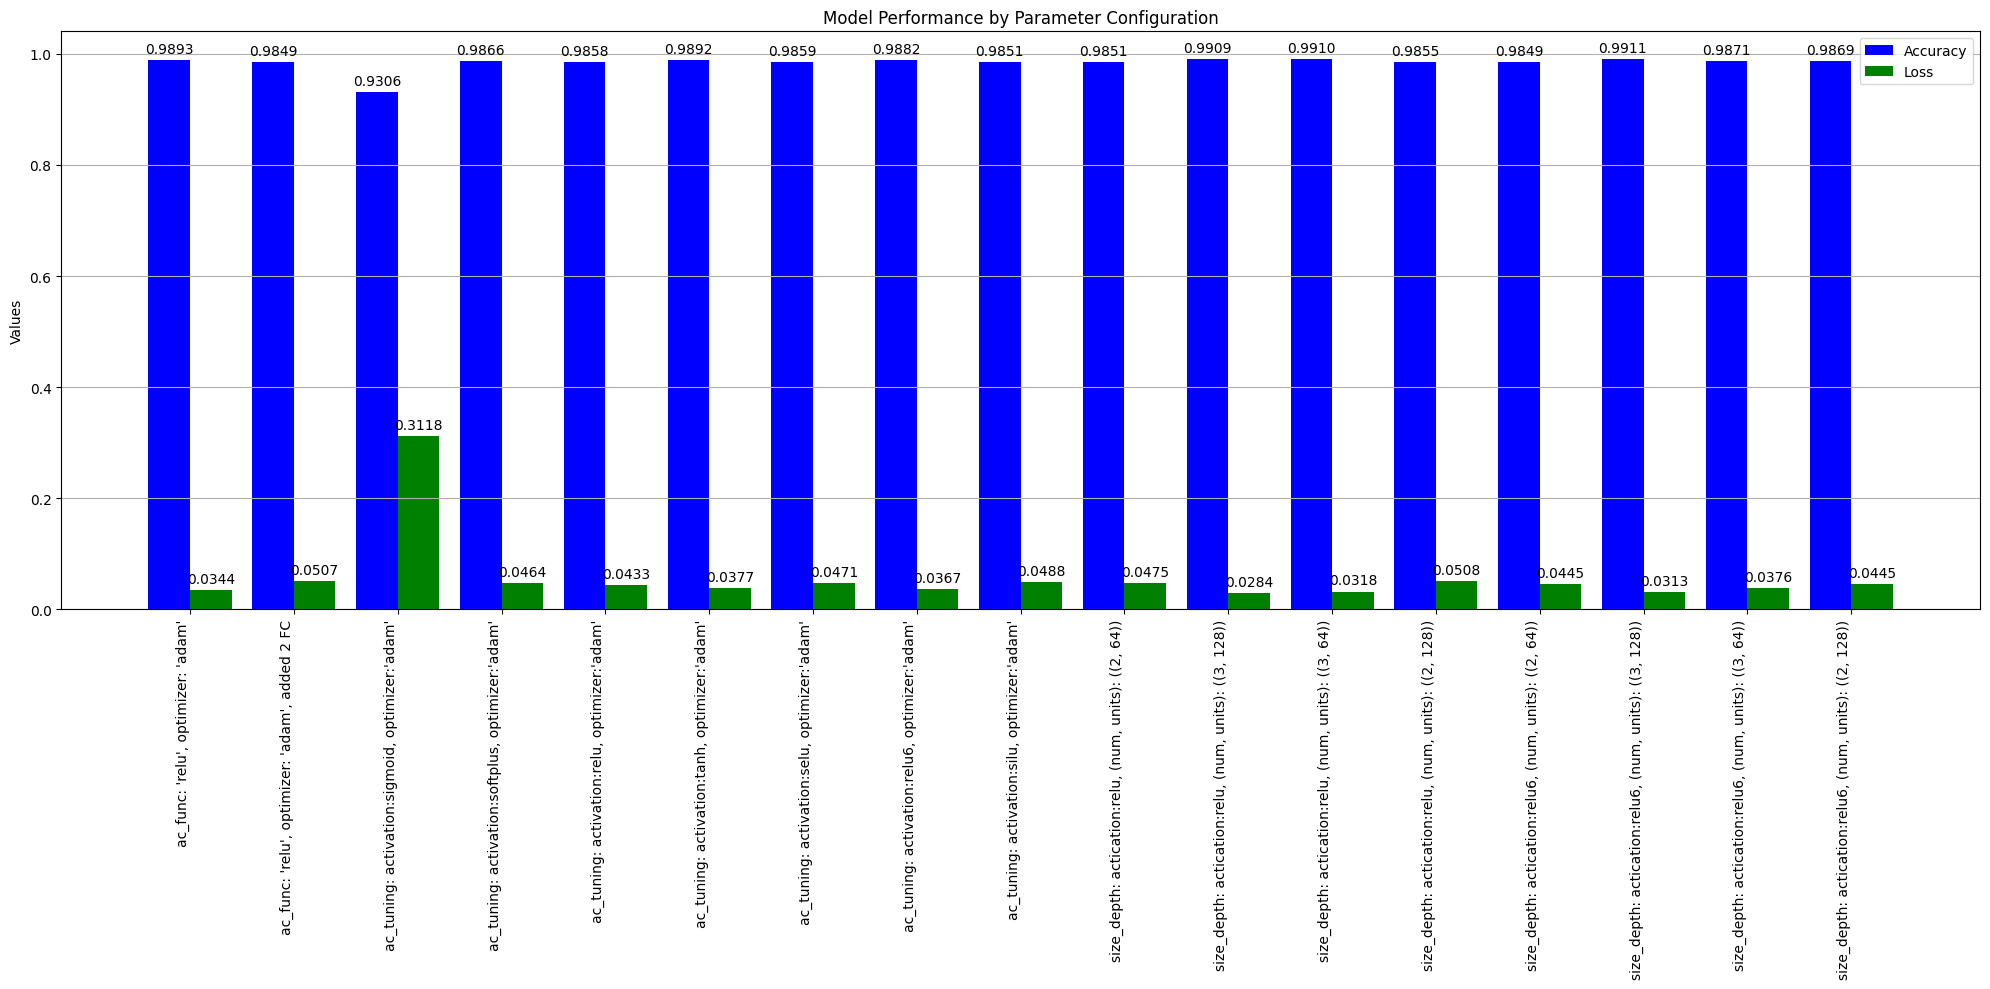

In [ ]:
visualize_result(test_result)

In [ ]:
test_result

,loss,accuracy,param
0,0.034437,0.9893,"ac_func: 'relu', optimizer: 'adam'"
1,0.050685,0.9849,"ac_func: 'relu', optimizer: 'adam', added 2 FC"
2,0.311780,0.9306,"ac_tuning: activation:sigmoid, optimizer:'adam'"
3,0.046412,0.9866,"ac_tuning: activation:softplus, optimizer:'adam'"
4,0.043303,0.9858,"ac_tuning: activation:relu, optimizer:'adam'"
5,0.037682,0.9892,"ac_tuning: activation:tanh, optimizer:'adam'"
6,0.047063,0.9859,"ac_tuning: activation:selu, optimizer:'adam'"
7,0.036714,0.9882,"ac_tuning: activation:relu6, optimizer:'adam'"
8,0.048827,0.9851,"ac_tuning: activation:silu, optimizer:'adam'"
9,0.047498,0.9851,"size_depth: actication:relu, (num, units): ((2..."


#### Experiment with various optimizers (https://keras.io/api/optimizers/) and learning rate. What is the effect on the resulting model accuracy?


Optimizers are algorithms used to change the attributes like weights and learning rate of the neural network, in order to reduce the losses. Optimizers guide the training process towards the minimum of the loss function. This process involves calculating the gradient of the loss function with respect to each weight by the chain rule and adjusting the weights using this information

in this step, I choose four optimizers and trained the best configuration from the previous experiment on it.
The Optimizers used are:
1. **SGD (Stochastic Gradient Descent):**
   - SGD updates the parameters of the model by calculating the gradient of the loss function with respect to the parameters for a subset of the data (a mini-batch) rather than the entire dataset. This approach helps in speeding up the computation significantly, especially for large datasets. The parameters are updated in the opposite direction of the gradient to minimize the loss. SGD often requires careful tuning of the learning rate and can be slow to converge.

2. **SGD with Momentum:**
   - SGD with Momentum is an extension of the basic SGD algorithm that accelerates the convergence towards the minimum of the loss function. It achieves this by incorporating a velocity component, which is a fraction of the previous updates. This addition helps to build up speed in directions with persistent gradient, thereby reducing oscillation and leading to faster convergence. It's particularly useful for navigating through the ravines of the loss landscape where the surface curves much more steeply in one dimension than in another.

3. **Adam (Adaptive Moment Estimation):**
   - Adam is an optimization algorithm that combines ideas from both Momentum and RMSprop (Root Mean Square Propagation). Besides keeping an exponentially decaying average of past squared gradients (like RMSprop), Adam also keeps an exponentially decaying average of past gradients, similar to momentum. It calculates adaptive learning rates for each parameter. Adam is often recommended as the default algorithm for training neural networks because of its robustness and effectiveness across a wide variety of models and problems.

4. **RMSProp (Root Mean Square Propagation):**
   - RMSProp is an optimizer that utilizes the magnitude of recent gradients to normalize the gradients. It does this by keeping a moving average of the squared gradients for each weight, and dividing the gradient by the square root of this average. This ensures that the steps are normalized, which means the algorithm takes steps of approximately the same size in all directions. It works well in practice and competes with Adam for many types of models.

Using the SGD and SGD with momentun the models could not converge at a solution that minimizes the loss as much as adam and rmse quickly.
The adam optimizer had the best accuracy and RMSE had the second best.





In [ ]:
def make_model(optimizer):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu6', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu6'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu6'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),

        layers.Dense(384, activation='relu6'),
        layers.Dense(256, activation='relu6'),
        layers.Dense(128, activation='relu6'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
optimizers = {
     'SGD': SGD(learning_rate=0.01),
     'SGD_momentum': SGD(learning_rate=0.01, momentum=0.9),
    'Adam': Adam(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001)
}


Epoch 1/6
399/399 [==============================] - 72s 179ms/step - loss: 2.2449 - accuracy: 0.3652 - val_loss: 2.0805 - val_accuracy: 0.4539
Epoch 2/6
399/399 [==============================] - 73s 182ms/step - loss: 1.1593 - accuracy: 0.6630 - val_loss: 0.5214 - val_accuracy: 0.8470
Epoch 3/6
399/399 [==============================] - 71s 178ms/step - loss: 0.3961 - accuracy: 0.8781 - val_loss: 0.3020 - val_accuracy: 0.9043
Epoch 4/6
399/399 [==============================] - 70s 175ms/step - loss: 0.2580 - accuracy: 0.9209 - val_loss: 0.3158 - val_accuracy: 0.9002
Epoch 5/6
399/399 [==============================] - 70s 176ms/step - loss: 0.2093 - accuracy: 0.9352 - val_loss: 0.1993 - val_accuracy: 0.9400
Epoch 6/6
399/399 [==============================] - 73s 183ms/step - loss: 0.1738 - accuracy: 0.9462 - val_loss: 0.1529 - val_accuracy: 0.9524
79/79 - 3s - loss: 0.1459 - accuracy: 0.9532 - 3s/epoch - 36ms/step

Test accuracy: 0.9531999826431274 



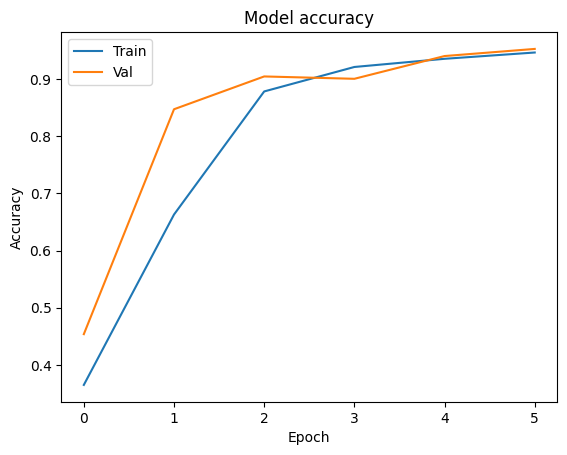

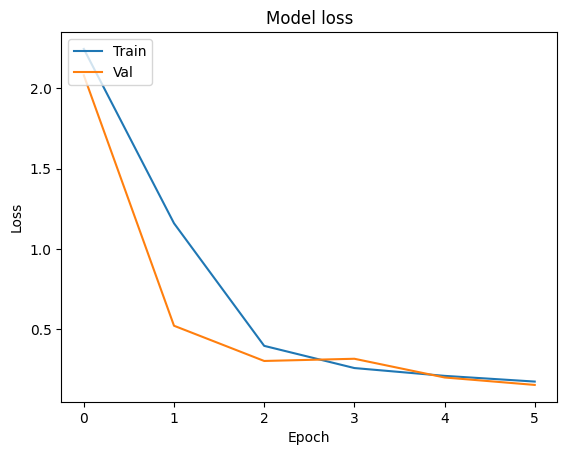

Epoch 1/6
399/399 [==============================] - 74s 183ms/step - loss: 0.7848 - accuracy: 0.7551 - val_loss: 0.1851 - val_accuracy: 0.9453
Epoch 2/6
399/399 [==============================] - 73s 183ms/step - loss: 0.1394 - accuracy: 0.9563 - val_loss: 0.1063 - val_accuracy: 0.9662
Epoch 3/6
399/399 [==============================] - 73s 182ms/step - loss: 0.0909 - accuracy: 0.9721 - val_loss: 0.0720 - val_accuracy: 0.9786
Epoch 4/6
399/399 [==============================] - 73s 184ms/step - loss: 0.0698 - accuracy: 0.9779 - val_loss: 0.0600 - val_accuracy: 0.9807
Epoch 5/6
399/399 [==============================] - 72s 182ms/step - loss: 0.0549 - accuracy: 0.9825 - val_loss: 0.0395 - val_accuracy: 0.9867
Epoch 6/6
399/399 [==============================] - 71s 179ms/step - loss: 0.0451 - accuracy: 0.9861 - val_loss: 0.0508 - val_accuracy: 0.9830
79/79 - 3s - loss: 0.0723 - accuracy: 0.9764 - 3s/epoch - 36ms/step

Test accuracy: 0.9764000177383423 



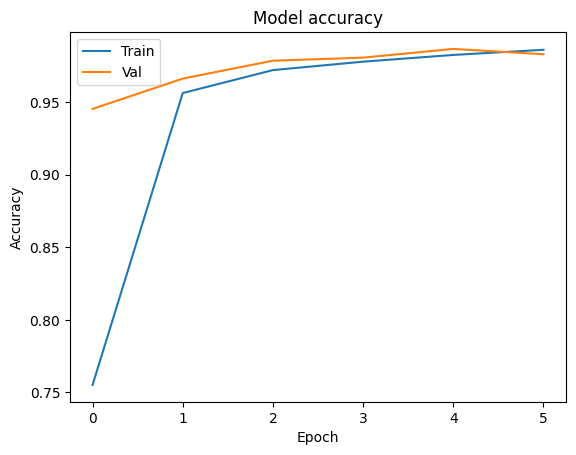

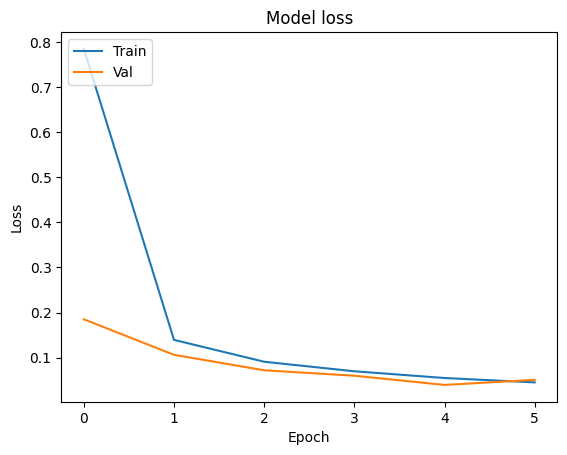

Epoch 1/6
399/399 [==============================] - 74s 181ms/step - loss: 0.3088 - accuracy: 0.9018 - val_loss: 0.0964 - val_accuracy: 0.9697
Epoch 2/6
399/399 [==============================] - 70s 177ms/step - loss: 0.0864 - accuracy: 0.9726 - val_loss: 0.0696 - val_accuracy: 0.9783
Epoch 3/6
399/399 [==============================] - 72s 179ms/step - loss: 0.0599 - accuracy: 0.9814 - val_loss: 0.0546 - val_accuracy: 0.9824
Epoch 4/6
399/399 [==============================] - 73s 183ms/step - loss: 0.0474 - accuracy: 0.9852 - val_loss: 0.0437 - val_accuracy: 0.9876
Epoch 5/6
399/399 [==============================] - 73s 183ms/step - loss: 0.0369 - accuracy: 0.9886 - val_loss: 0.0387 - val_accuracy: 0.9884
Epoch 6/6
399/399 [==============================] - 73s 182ms/step - loss: 0.0336 - accuracy: 0.9892 - val_loss: 0.0236 - val_accuracy: 0.9928
79/79 - 4s - loss: 0.0500 - accuracy: 0.9868 - 4s/epoch - 49ms/step

Test accuracy: 0.9868000149726868 



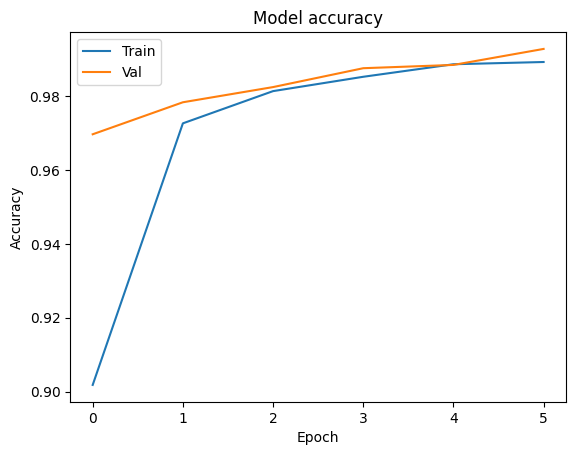

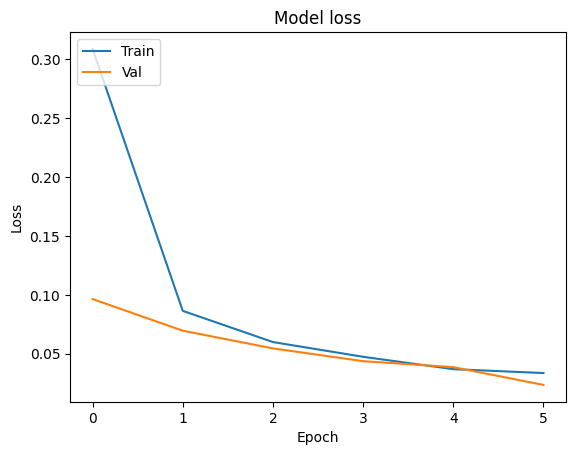

Epoch 1/6
399/399 [==============================] - 74s 183ms/step - loss: 0.4381 - accuracy: 0.8566 - val_loss: 0.1445 - val_accuracy: 0.9577
Epoch 2/6
399/399 [==============================] - 71s 178ms/step - loss: 0.0889 - accuracy: 0.9732 - val_loss: 0.0986 - val_accuracy: 0.9716
Epoch 3/6
399/399 [==============================] - 73s 182ms/step - loss: 0.0572 - accuracy: 0.9827 - val_loss: 0.0323 - val_accuracy: 0.9903
Epoch 4/6
399/399 [==============================] - 70s 176ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0397 - val_accuracy: 0.9889
Epoch 5/6
399/399 [==============================] - 72s 181ms/step - loss: 0.0324 - accuracy: 0.9901 - val_loss: 0.0401 - val_accuracy: 0.9877
Epoch 6/6
399/399 [==============================] - 72s 181ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.0207 - val_accuracy: 0.9943
79/79 - 3s - loss: 0.0514 - accuracy: 0.9867 - 3s/epoch - 36ms/step

Test accuracy: 0.9866999983787537 



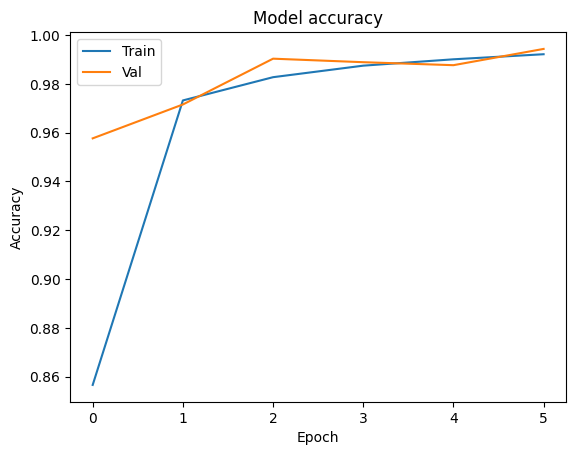

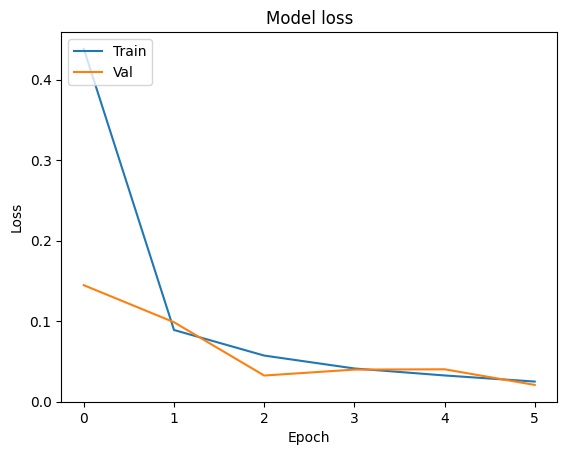

In [ ]:
history_tables = pd.DataFrame()

for opt_name, optimizer in optimizers.items():
    model = make_model(optimizer)
    history = train(ds_train, ds_val, model=model)
    params_desc= f"optimizer: activation:relu6, optimizer:{opt_name}"

    history_table = model_evaluate(model, history, params_desc, ds_test)
    history_table['optimizer'] = opt_name

  # Concatenating the new results
    history_tables = pd.concat([history_tables, history_table], ignore_index=True)

history_tables.to_csv("optimizer_result.csv")


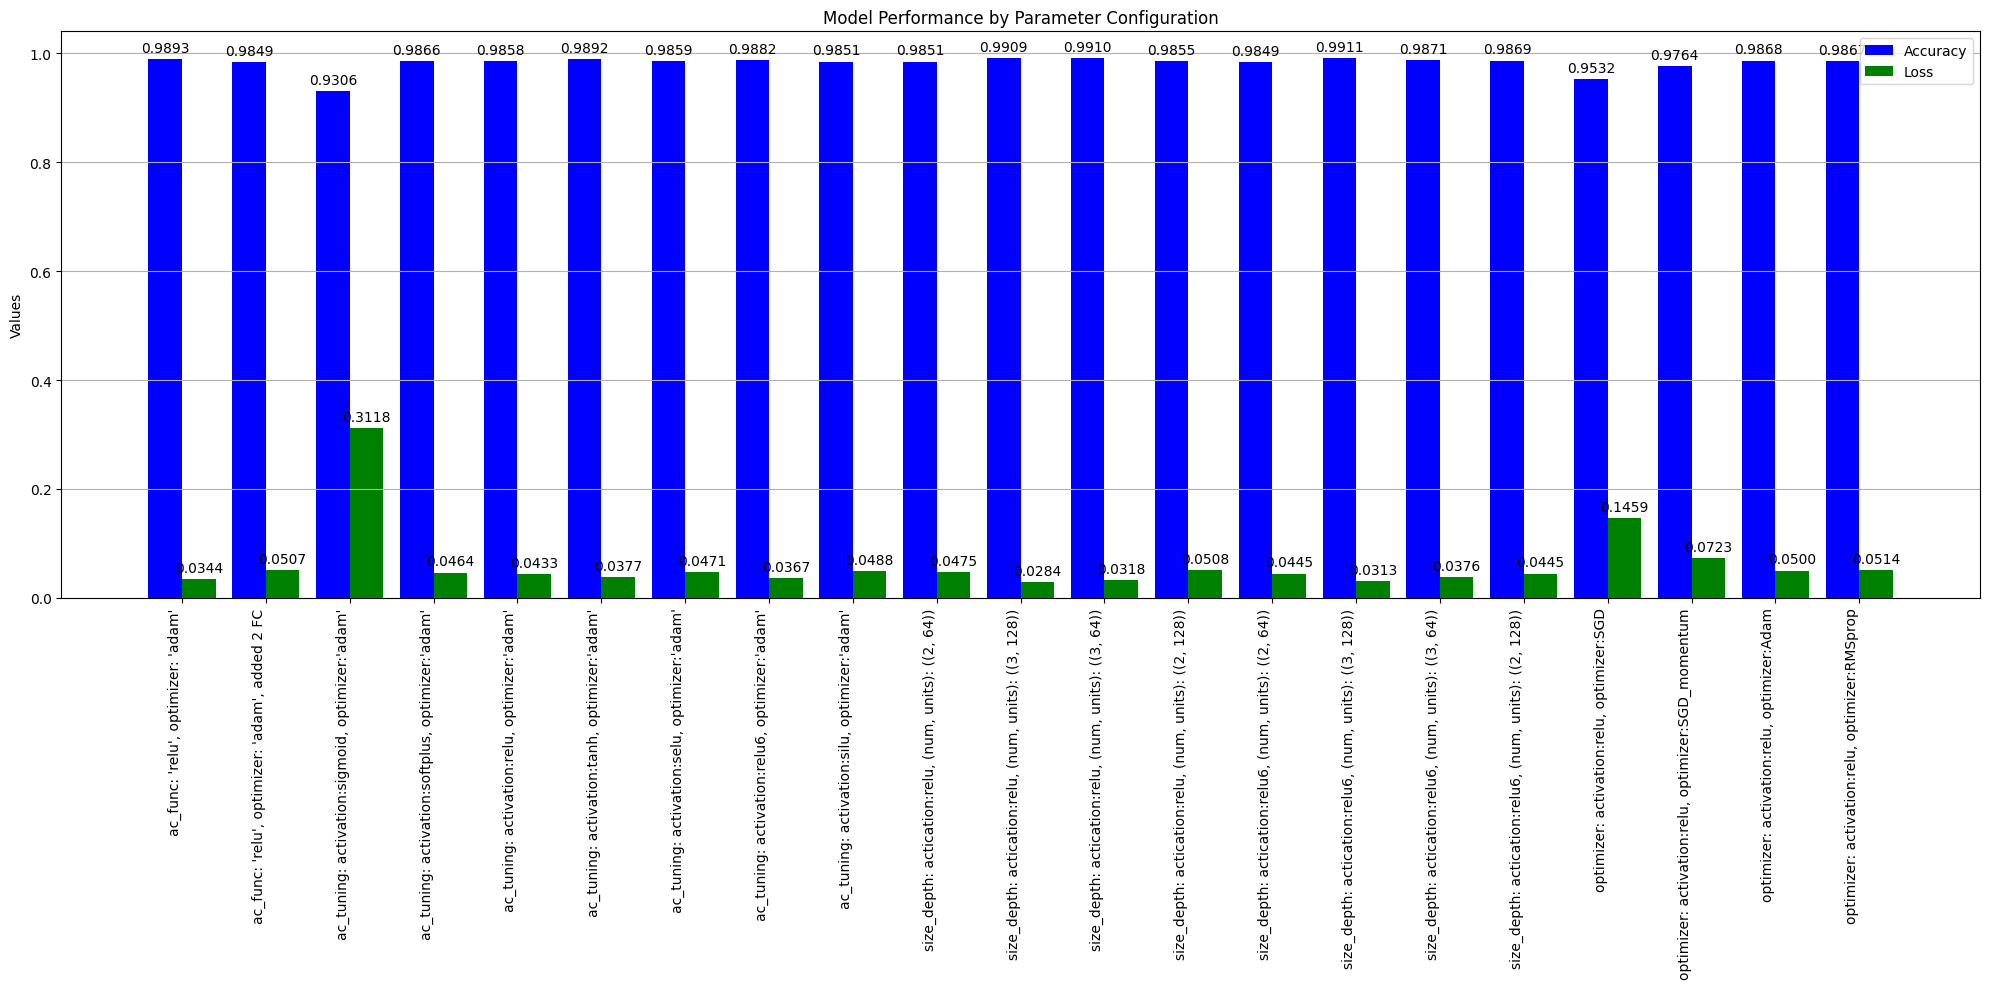

In [ ]:
visualize_result(test_result)

#### 5e. Experiment with various batch sizes and epochs for training (see https://keras.io/api/models/model_training_apis/)


This goal of this section is to detemin the best batch size and epoch for training the model.  To do this I utilized the best parameters with the highest values for test accuracy from the previous section, then I trained the models on selected combination of batch sizes and epochs.

This section contains the training of the model with adam and rmse activation function on several epochs and batch sizes to find the best function and the optimal batch size and epochs to use.

The RMSEProp optimizer with batch_size of 256 and 10 epochs had the highest performance in with an accuracy of 98.99%




**Batch Size**: The batch size is the number of training samples used in one iteration. The choice of batch size can affect your model in several ways:

* **Memory Usage**: Larger batches increase memory demands, as more data must be processed simultaneously.
* Convergence Speed: Smaller batches can lead to quicker convergence due to more frequent weight updates, though too small batches may cause instability from noisy gradients.
* Generalization: Smaller batch sizes often yield better generalization and less overfitting. Larger batches provide more accurate gradient estimates but may lead to less effective generalization.
* Training Speed: Larger batches can exploit parallel architectures more efficiently, potentially speeding up training per epoch. However, excessively large batches may not further improve speed and could even hinder it due to hardware constraints.

**Epochs**: An epoch represents a complete pass through the entire training dataset. The number of epochs affects training in the following ways:

* **Underfitting vs. Overfitting**: Too few epochs can result in underfitting, while too many epochs might cause overfitting, where the model learns noise specific to the training data.
* Convergence: More epochs can improve convergence, optimizing model parameters better. However, gains might diminish beyond a certain point, making additional training less beneficial.



In [ ]:
def make_model(optimizer):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu6', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu6'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu6'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),

        layers.Dense(384, activation='relu6'),
        layers.Dense(256, activation='relu6'),
        layers.Dense(128, activation='relu6'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
batch_sizes = [128,256]
epochs_list = [5, 10]

Epoch 1/5
399/399 - 68s - loss: 0.4087 - accuracy: 0.8674 - val_loss: 0.1593 - val_accuracy: 0.9540 - 68s/epoch - 171ms/step
Epoch 2/5
399/399 - 68s - loss: 0.0863 - accuracy: 0.9742 - val_loss: 0.0920 - val_accuracy: 0.9684 - 68s/epoch - 170ms/step
Epoch 3/5
399/399 - 69s - loss: 0.0546 - accuracy: 0.9835 - val_loss: 0.0399 - val_accuracy: 0.9869 - 69s/epoch - 173ms/step
Epoch 4/5
399/399 - 67s - loss: 0.0384 - accuracy: 0.9886 - val_loss: 0.0305 - val_accuracy: 0.9908 - 67s/epoch - 168ms/step
Epoch 5/5
399/399 - 67s - loss: 0.0310 - accuracy: 0.9908 - val_loss: 0.0277 - val_accuracy: 0.9919 - 67s/epoch - 167ms/step
79/79 - 3s - loss: 0.0514 - accuracy: 0.9867 - 3s/epoch - 36ms/step

Test accuracy: 0.9866999983787537 



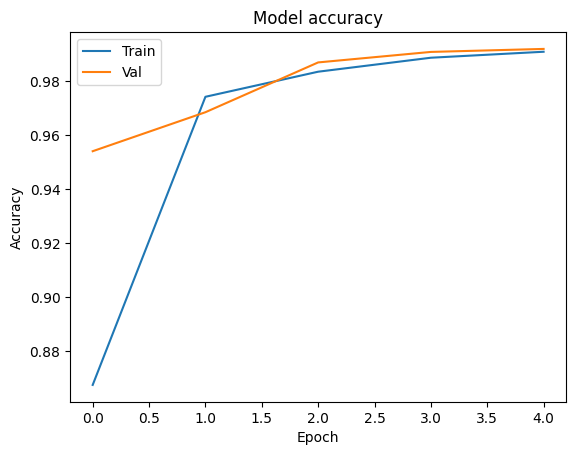

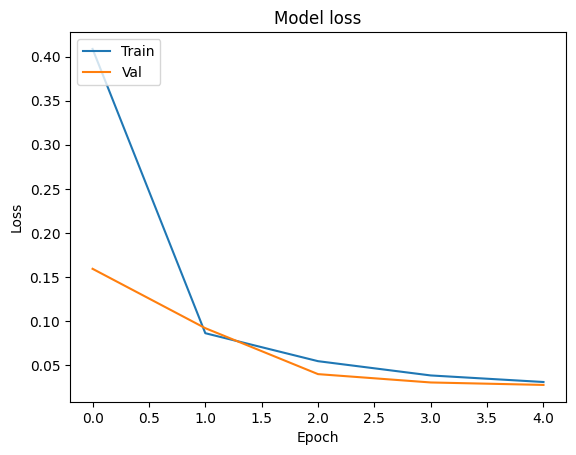

Epoch 1/10
399/399 - 70s - loss: 0.3928 - accuracy: 0.8721 - val_loss: 0.1451 - val_accuracy: 0.9541 - 70s/epoch - 177ms/step
Epoch 2/10
399/399 - 69s - loss: 0.0815 - accuracy: 0.9755 - val_loss: 0.1020 - val_accuracy: 0.9710 - 69s/epoch - 173ms/step
Epoch 3/10
399/399 - 67s - loss: 0.0534 - accuracy: 0.9838 - val_loss: 0.0355 - val_accuracy: 0.9882 - 67s/epoch - 167ms/step
Epoch 4/10
399/399 - 66s - loss: 0.0381 - accuracy: 0.9885 - val_loss: 0.0245 - val_accuracy: 0.9928 - 66s/epoch - 166ms/step
Epoch 5/10
399/399 - 67s - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.0218 - val_accuracy: 0.9934 - 67s/epoch - 169ms/step
Epoch 6/10
399/399 - 69s - loss: 0.0216 - accuracy: 0.9930 - val_loss: 0.0442 - val_accuracy: 0.9877 - 69s/epoch - 173ms/step
Epoch 7/10
399/399 - 69s - loss: 0.0183 - accuracy: 0.9945 - val_loss: 0.0143 - val_accuracy: 0.9964 - 69s/epoch - 172ms/step
Epoch 8/10
399/399 - 69s - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.0119 - val_accuracy: 0.9972 - 69s/epoch - 173

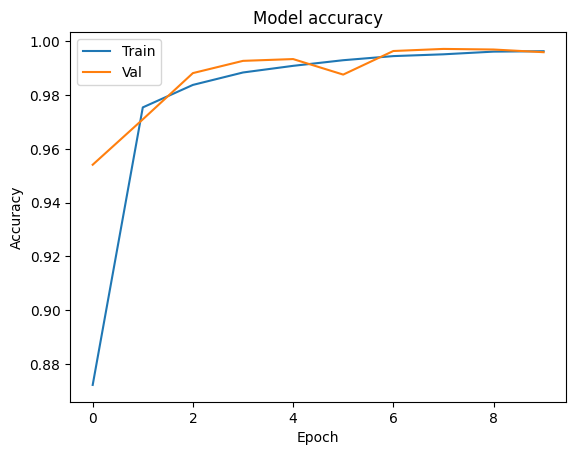

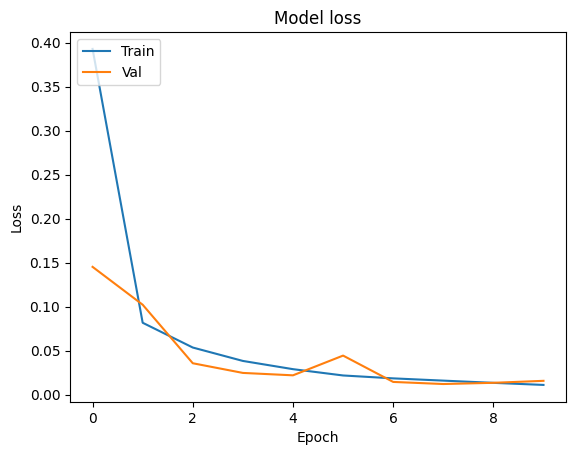

Epoch 1/5
399/399 - 74s - loss: 0.3960 - accuracy: 0.8710 - val_loss: 0.0894 - val_accuracy: 0.9723 - 74s/epoch - 186ms/step
Epoch 2/5
399/399 - 72s - loss: 0.0839 - accuracy: 0.9747 - val_loss: 0.0583 - val_accuracy: 0.9813 - 72s/epoch - 181ms/step
Epoch 3/5
399/399 - 73s - loss: 0.0546 - accuracy: 0.9834 - val_loss: 0.0320 - val_accuracy: 0.9901 - 73s/epoch - 183ms/step
Epoch 4/5
399/399 - 71s - loss: 0.0397 - accuracy: 0.9882 - val_loss: 0.0281 - val_accuracy: 0.9918 - 71s/epoch - 177ms/step
Epoch 5/5
399/399 - 71s - loss: 0.0307 - accuracy: 0.9908 - val_loss: 0.0481 - val_accuracy: 0.9840 - 71s/epoch - 179ms/step
79/79 - 3s - loss: 0.0815 - accuracy: 0.9782 - 3s/epoch - 36ms/step

Test accuracy: 0.9782000184059143 



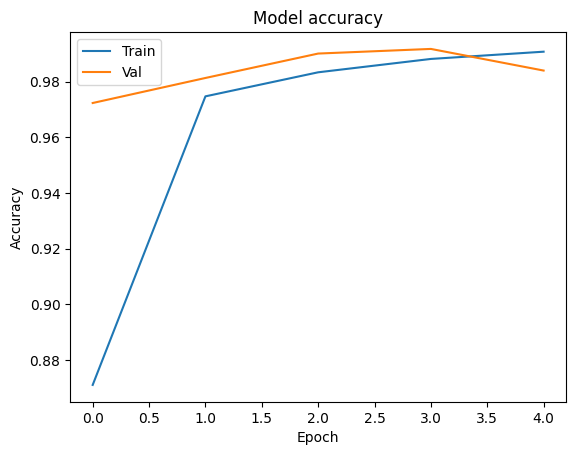

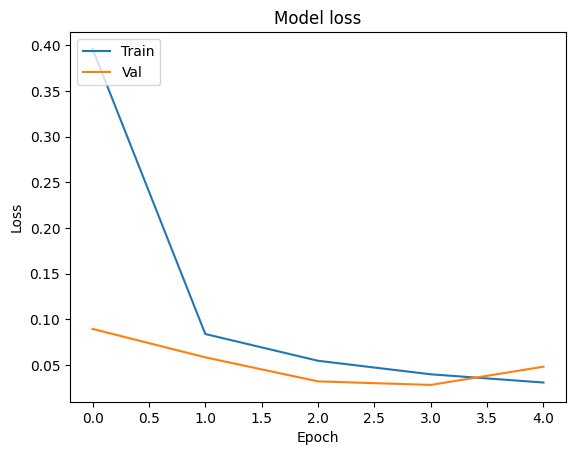

Epoch 1/10
399/399 - 69s - loss: 0.4259 - accuracy: 0.8637 - val_loss: 0.1300 - val_accuracy: 0.9606 - 69s/epoch - 172ms/step
Epoch 2/10
399/399 - 68s - loss: 0.0867 - accuracy: 0.9751 - val_loss: 0.0601 - val_accuracy: 0.9820 - 68s/epoch - 169ms/step
Epoch 3/10
399/399 - 69s - loss: 0.0556 - accuracy: 0.9837 - val_loss: 0.0328 - val_accuracy: 0.9900 - 69s/epoch - 174ms/step
Epoch 4/10
399/399 - 69s - loss: 0.0398 - accuracy: 0.9887 - val_loss: 0.0506 - val_accuracy: 0.9842 - 69s/epoch - 173ms/step
Epoch 5/10
399/399 - 66s - loss: 0.0304 - accuracy: 0.9903 - val_loss: 0.0469 - val_accuracy: 0.9860 - 66s/epoch - 166ms/step
Epoch 6/10
399/399 - 69s - loss: 0.0244 - accuracy: 0.9926 - val_loss: 0.0275 - val_accuracy: 0.9918 - 69s/epoch - 173ms/step
Epoch 7/10
399/399 - 69s - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.0218 - val_accuracy: 0.9939 - 69s/epoch - 173ms/step
Epoch 8/10
399/399 - 67s - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.0166 - val_accuracy: 0.9958 - 67s/epoch - 167

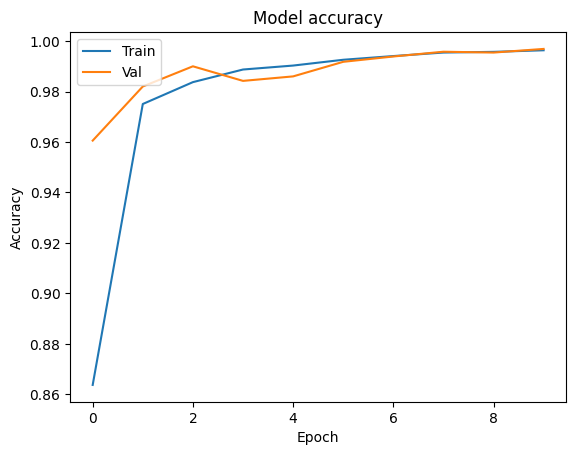

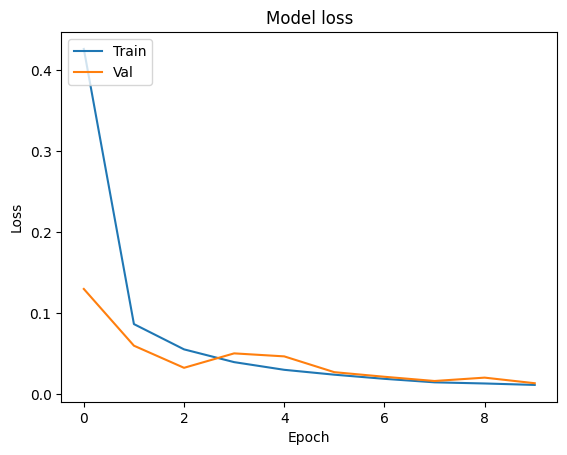

In [ ]:
history_tables = pd.DataFrame()

for batch_size in batch_sizes:
    for epochs in epochs_list:
        model = make_model('RMSprop')

        # Train the model. Assume 'ds_train' and 'ds_val' are your datasets.
        # Adjust the `fit` method call to use the current batch_size and epochs.
        history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, batch_size=batch_size, verbose=2)
        params_desc= f"batch_epoch: batch_size:{batch_size},  epochs:{epochs}"
        history_table = model_evaluate(model, history, params_desc, ds_test)
        history_table['batch_size'] = batch_size
        history_table['epochs'] = epochs

        # Concatenating the new results
        history_tables = pd.concat([history_tables, history_table], ignore_index=True)



In [ ]:
history_tables.to_csv("batch_size_epoch.csv")

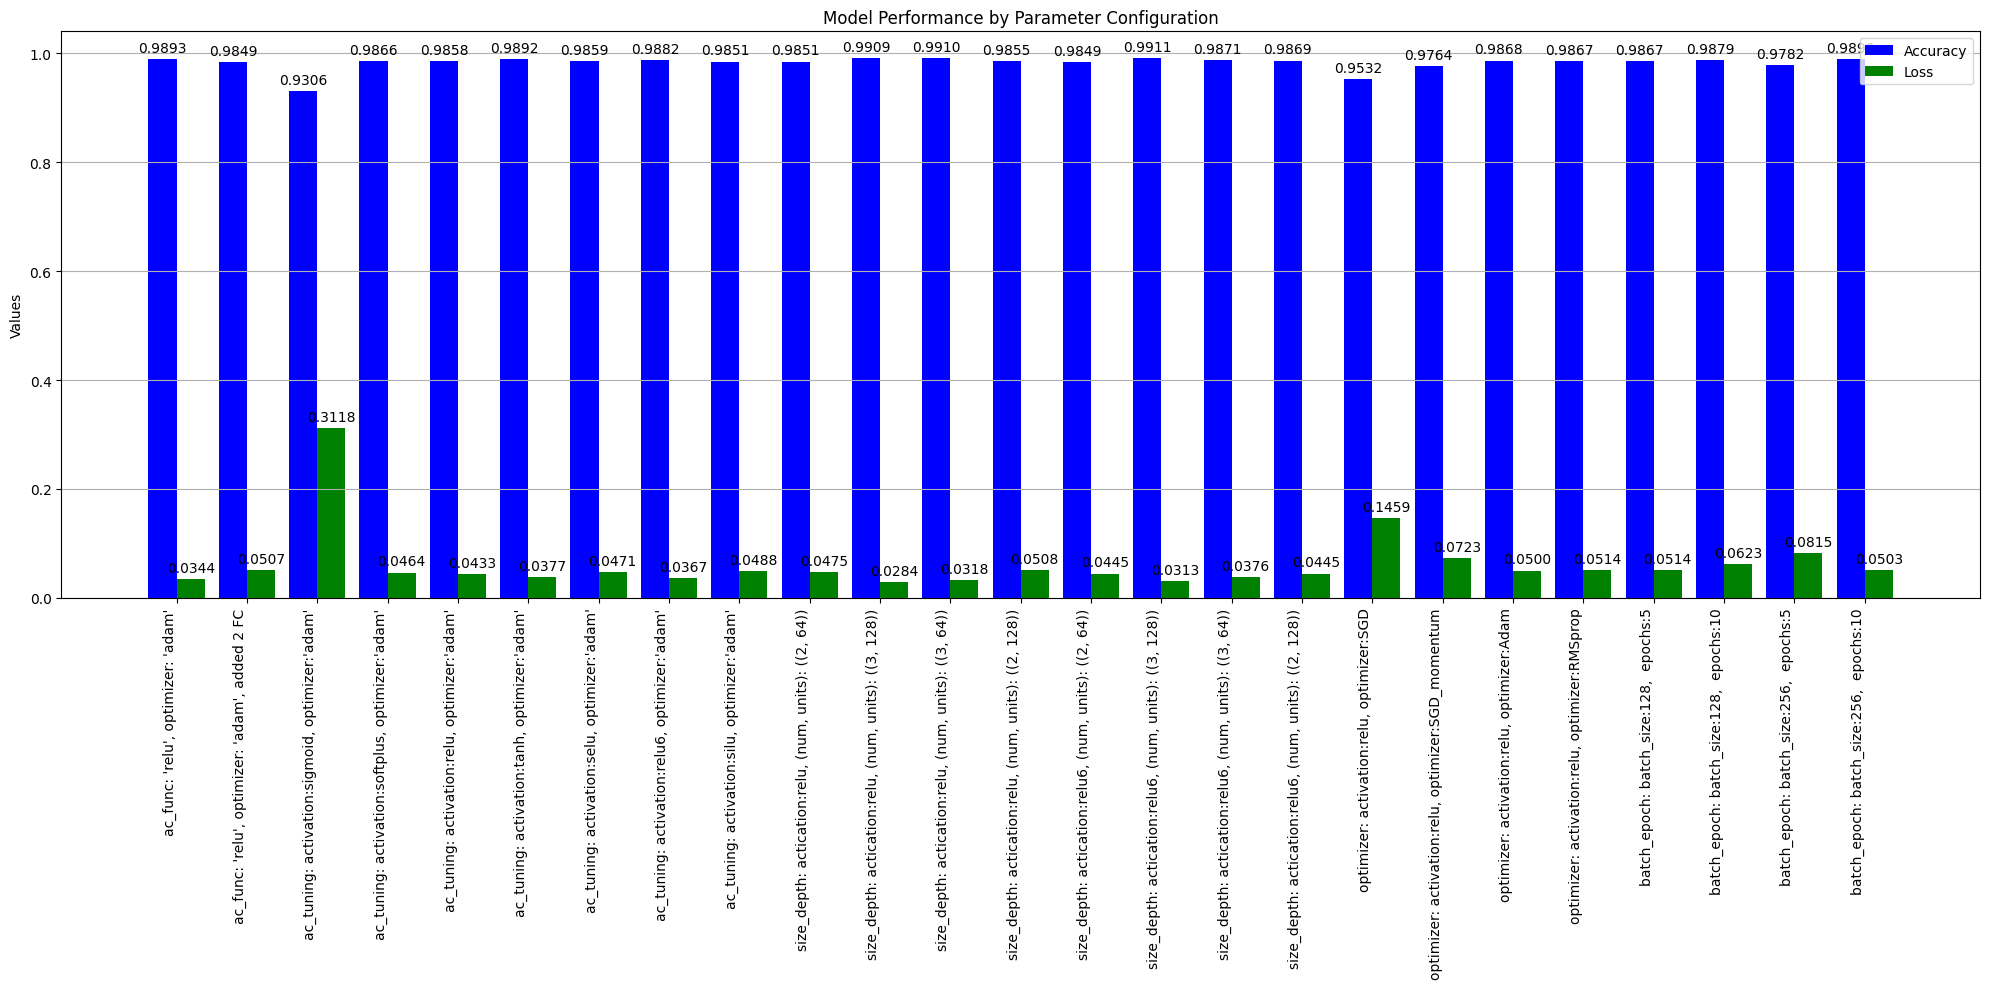

In [ ]:
visualize_result(test_result)

Epoch 1/5
399/399 - 53s - loss: 0.3463 - accuracy: 0.8915 - val_loss: 0.1025 - val_accuracy: 0.9703 - 53s/epoch - 134ms/step
Epoch 2/5
399/399 - 51s - loss: 0.0954 - accuracy: 0.9706 - val_loss: 0.0621 - val_accuracy: 0.9801 - 51s/epoch - 127ms/step
Epoch 3/5
399/399 - 53s - loss: 0.0684 - accuracy: 0.9784 - val_loss: 0.0521 - val_accuracy: 0.9834 - 53s/epoch - 134ms/step
Epoch 4/5
399/399 - 51s - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.0356 - val_accuracy: 0.9898 - 51s/epoch - 129ms/step
Epoch 5/5
399/399 - 50s - loss: 0.0408 - accuracy: 0.9875 - val_loss: 0.0545 - val_accuracy: 0.9834 - 50s/epoch - 126ms/step
79/79 - 3s - loss: 0.0739 - accuracy: 0.9779 - 3s/epoch - 41ms/step

Test accuracy: 0.9779000282287598 



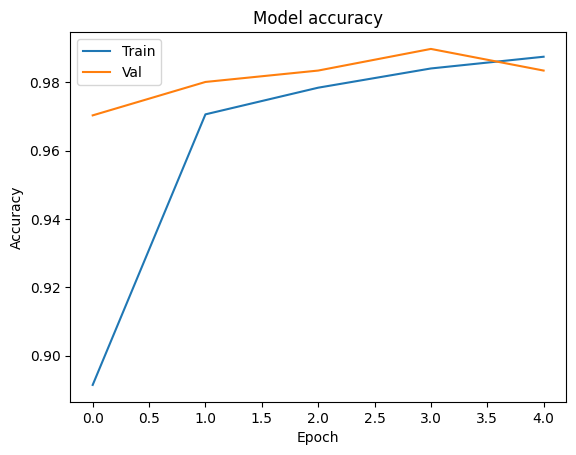

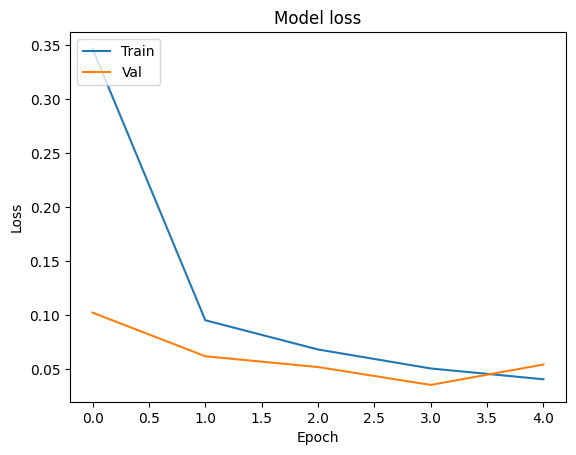

Epoch 1/10
399/399 - 52s - loss: 0.3415 - accuracy: 0.8906 - val_loss: 0.1095 - val_accuracy: 0.9659 - 52s/epoch - 132ms/step
Epoch 2/10
399/399 - 50s - loss: 0.0984 - accuracy: 0.9695 - val_loss: 0.0737 - val_accuracy: 0.9771 - 50s/epoch - 126ms/step
Epoch 3/10
399/399 - 53s - loss: 0.0674 - accuracy: 0.9793 - val_loss: 0.0479 - val_accuracy: 0.9847 - 53s/epoch - 133ms/step
Epoch 4/10
399/399 - 50s - loss: 0.0517 - accuracy: 0.9837 - val_loss: 0.0450 - val_accuracy: 0.9853 - 50s/epoch - 125ms/step
Epoch 5/10
399/399 - 49s - loss: 0.0439 - accuracy: 0.9868 - val_loss: 0.0376 - val_accuracy: 0.9880 - 49s/epoch - 123ms/step
Epoch 6/10
399/399 - 49s - loss: 0.0343 - accuracy: 0.9892 - val_loss: 0.0345 - val_accuracy: 0.9896 - 49s/epoch - 124ms/step
Epoch 7/10
399/399 - 52s - loss: 0.0293 - accuracy: 0.9909 - val_loss: 0.0439 - val_accuracy: 0.9860 - 52s/epoch - 129ms/step
Epoch 8/10
399/399 - 51s - loss: 0.0259 - accuracy: 0.9915 - val_loss: 0.0232 - val_accuracy: 0.9928 - 51s/epoch - 129

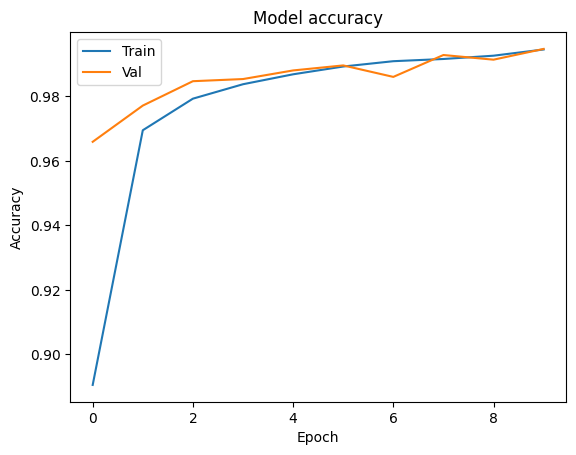

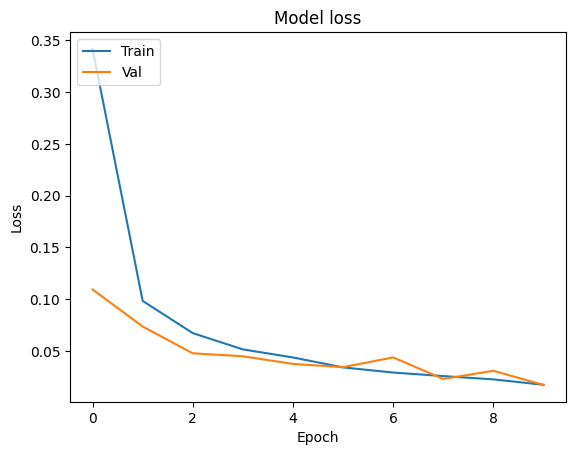

Epoch 1/5
399/399 - 54s - loss: 0.3270 - accuracy: 0.8977 - val_loss: 0.0981 - val_accuracy: 0.9700 - 54s/epoch - 137ms/step
Epoch 2/5
399/399 - 52s - loss: 0.0921 - accuracy: 0.9709 - val_loss: 0.0703 - val_accuracy: 0.9773 - 52s/epoch - 130ms/step
Epoch 3/5
399/399 - 52s - loss: 0.0676 - accuracy: 0.9793 - val_loss: 0.0455 - val_accuracy: 0.9853 - 52s/epoch - 129ms/step
Epoch 4/5
399/399 - 52s - loss: 0.0520 - accuracy: 0.9837 - val_loss: 0.0528 - val_accuracy: 0.9837 - 52s/epoch - 131ms/step
Epoch 5/5
399/399 - 50s - loss: 0.0429 - accuracy: 0.9869 - val_loss: 0.0322 - val_accuracy: 0.9893 - 50s/epoch - 125ms/step
79/79 - 2s - loss: 0.0548 - accuracy: 0.9826 - 2s/epoch - 31ms/step

Test accuracy: 0.9825999736785889 



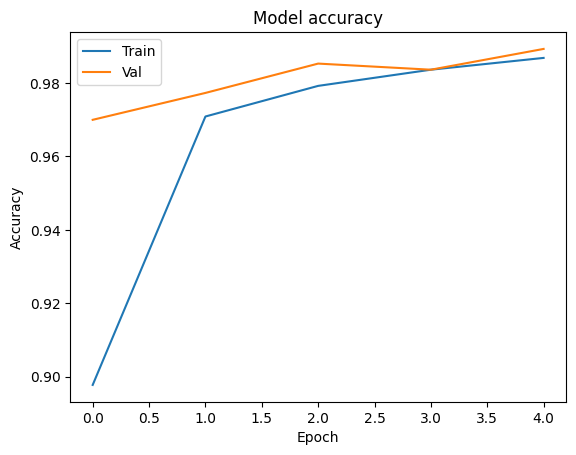

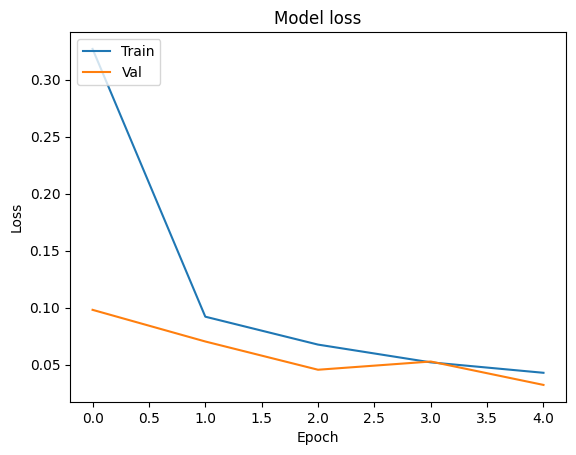

Epoch 1/10
399/399 - 52s - loss: 0.3161 - accuracy: 0.8977 - val_loss: 0.1206 - val_accuracy: 0.9629 - 52s/epoch - 131ms/step
Epoch 2/10
399/399 - 50s - loss: 0.0948 - accuracy: 0.9709 - val_loss: 0.0834 - val_accuracy: 0.9752 - 50s/epoch - 125ms/step
Epoch 3/10
399/399 - 49s - loss: 0.0611 - accuracy: 0.9814 - val_loss: 0.0839 - val_accuracy: 0.9750 - 49s/epoch - 122ms/step
Epoch 4/10
399/399 - 50s - loss: 0.0499 - accuracy: 0.9841 - val_loss: 0.0439 - val_accuracy: 0.9863 - 50s/epoch - 126ms/step
Epoch 5/10
399/399 - 50s - loss: 0.0405 - accuracy: 0.9871 - val_loss: 0.0319 - val_accuracy: 0.9901 - 50s/epoch - 126ms/step
Epoch 6/10
399/399 - 51s - loss: 0.0331 - accuracy: 0.9892 - val_loss: 0.0274 - val_accuracy: 0.9914 - 51s/epoch - 127ms/step
Epoch 7/10
399/399 - 50s - loss: 0.0281 - accuracy: 0.9913 - val_loss: 0.0253 - val_accuracy: 0.9921 - 50s/epoch - 126ms/step
Epoch 8/10
399/399 - 50s - loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.0205 - val_accuracy: 0.9939 - 50s/epoch - 126

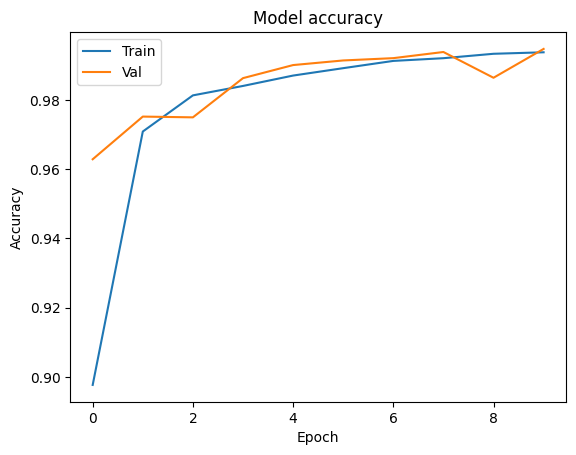

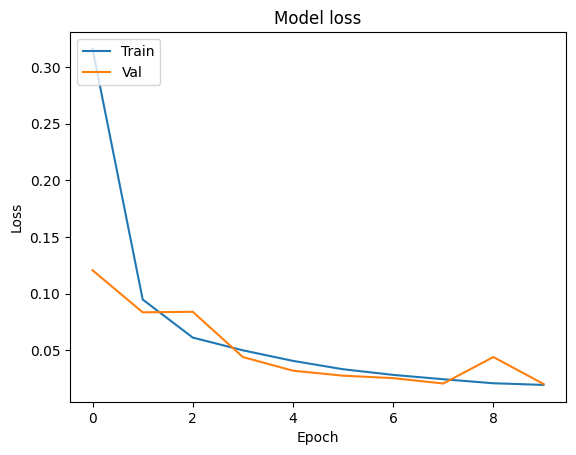

In [ ]:
history_tables = pd.DataFrame()

for batch_size in batch_sizes:
    for epochs in epochs_list:
        model = make_model('adam')

        # Train the model. Assume 'ds_train' and 'ds_val' are your datasets.
        # Adjust the `fit` method call to use the current batch_size and epochs.
        history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, batch_size=batch_size, verbose=2)
        params_desc= f"batch_epoch: batch_size:{batch_size},  epochs:{epochs}"
        history_table = model_evaluate(model, history, params_desc, ds_test)
        history_table['batch_size'] = batch_size
        history_table['epochs'] = epochs

        # Concatenating the new results
        history_tables = pd.concat([history_tables, history_table], ignore_index=True)




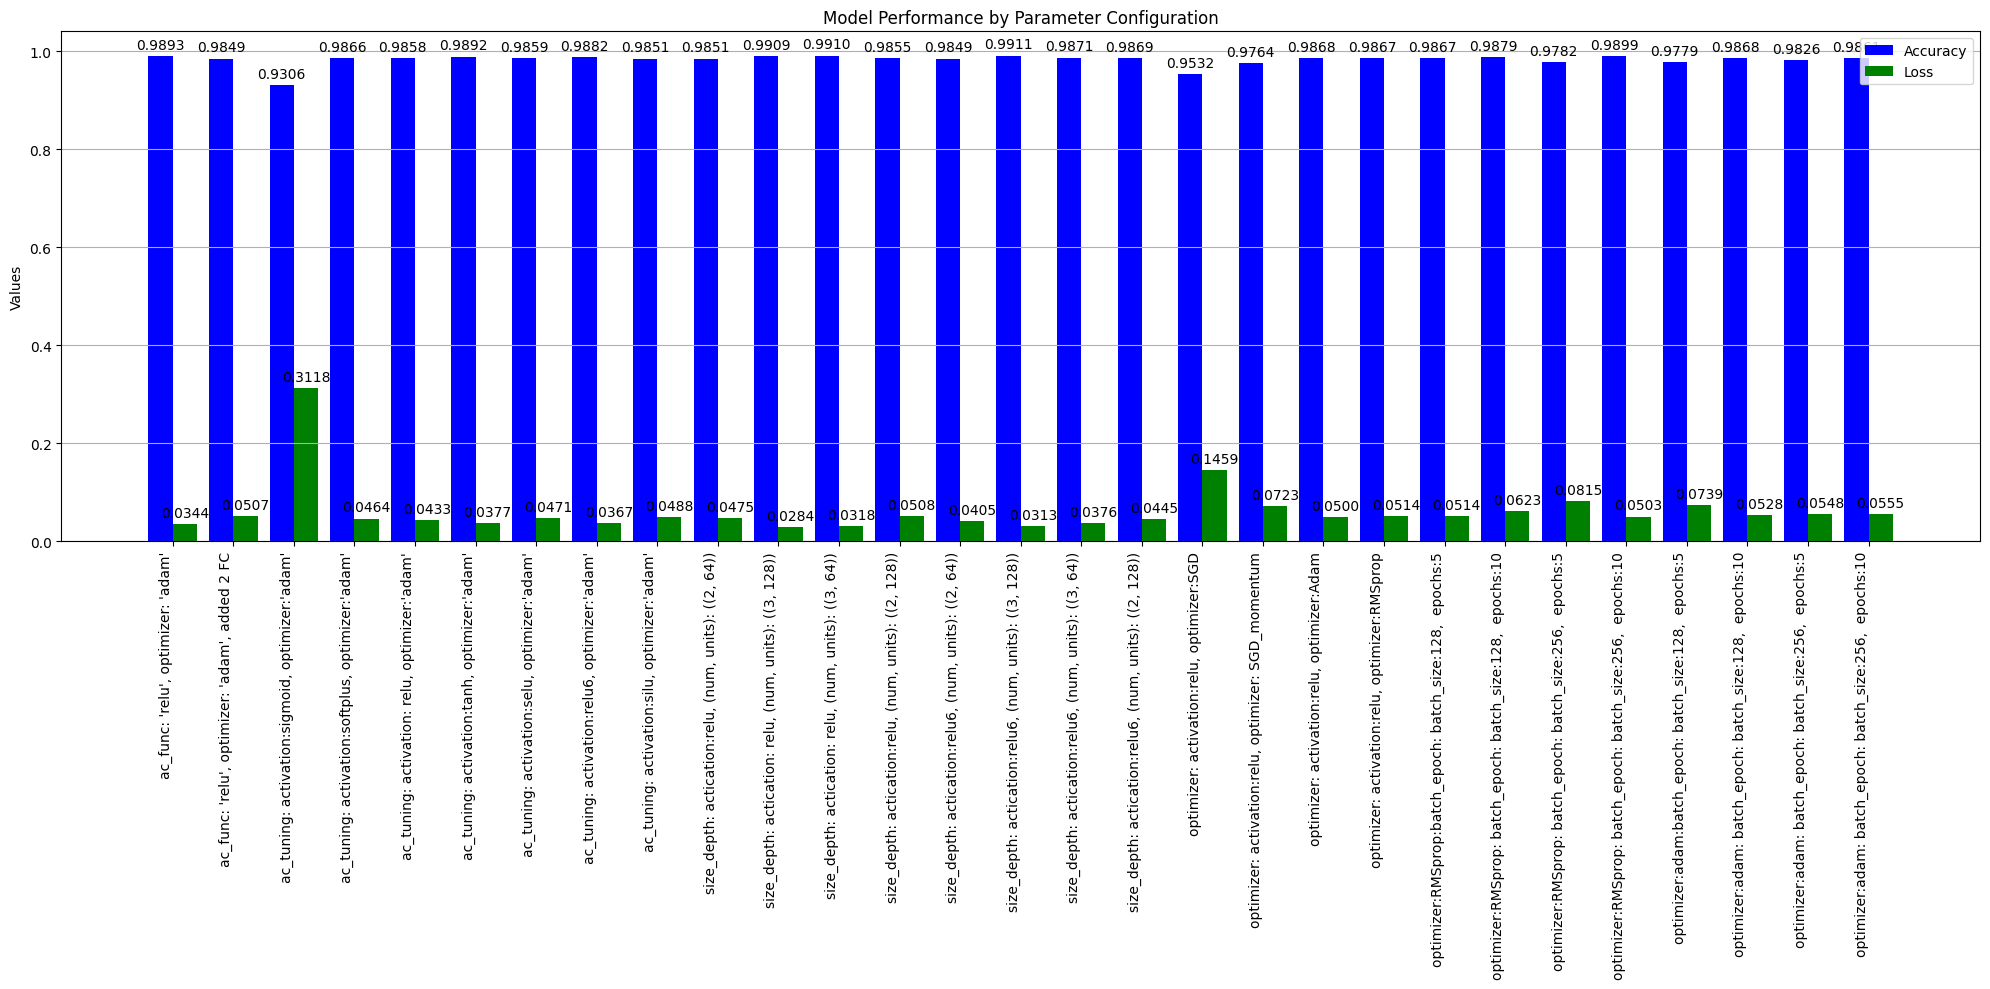

In [ ]:
visualize_result(test_result)

### Using early stopping to determine the best number of epochs to use

In this section, I used early stopping to determine the optimal epoch for the best configuration so far. Early stopping is a regularization technique that involves the monitoring of the performance of a model over several epochs and using the stop criterion determines when continuous training of the model will result in no improvement in the model's performance.

in this section we used the validation loss value to monitor the progress of the model such that if the model's loss does not improve over 5 epochs by a values of 0.01 then the training should stop.

The result showed that the most optimal number of epochs to train the model with is 8 and the accuracy of the model in classifying the test dataset was 98.89%.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min', restore_best_weights=True)


In [ ]:
model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu6', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu6'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu6'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),

        layers.Dense(384, activation='relu6'),
        layers.Dense(256, activation='relu6'),
        layers.Dense(128, activation='relu6'),
        layers.Dense(10, activation='softmax')
    ])

model.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_val, epochs=20, batch_size=128,callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print('\nTest accuracy:', test_acc, '\n')


Epoch 1/20
399/399 [==============================] - 80s 198ms/step - loss: 0.3922 - accuracy: 0.8737 - val_loss: 0.0656 - val_accuracy: 0.9799
Epoch 2/20
399/399 [==============================] - 85s 214ms/step - loss: 0.0822 - accuracy: 0.9749 - val_loss: 0.0973 - val_accuracy: 0.9693
Epoch 3/20
399/399 [==============================] - 85s 214ms/step - loss: 0.0526 - accuracy: 0.9839 - val_loss: 0.0334 - val_accuracy: 0.9894
Epoch 4/20
399/399 [==============================] - 81s 202ms/step - loss: 0.0391 - accuracy: 0.9884 - val_loss: 0.0382 - val_accuracy: 0.9878
Epoch 5/20
399/399 [==============================] - 70s 174ms/step - loss: 0.0301 - accuracy: 0.9907 - val_loss: 0.0193 - val_accuracy: 0.9938
Epoch 6/20
399/399 [==============================] - 66s 166ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0364 - val_accuracy: 0.9896
Epoch 7/20
399/399 [==============================] - 68s 171ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0249 - val_ac

#### 5f.What happens if we don't use any CNN layer? (considering the model in https://www.tensorflow.org/datasets/keras_example).

This section builds a model without using CNN for feature extraction. The without the CNN, the accuracy of the model on the test dataset was 97.93%. this implies that the model could not predict about 100 images correctly.

In [ ]:
model = models.Sequential([
    #first layer
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    layers.Dense(384, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_val, epochs=20, batch_size=256,callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print('\nTest accuracy:', test_acc, '\n')


Epoch 1/20
399/399 [==============================] - 40s 13ms/step - loss: 0.2828 - accuracy: 0.9119 - val_loss: 0.1125 - val_accuracy: 0.9677
Epoch 2/20
399/399 [==============================] - 6s 15ms/step - loss: 0.1025 - accuracy: 0.9678 - val_loss: 0.0554 - val_accuracy: 0.9846
Epoch 3/20
399/399 [==============================] - 5s 11ms/step - loss: 0.0676 - accuracy: 0.9789 - val_loss: 0.0538 - val_accuracy: 0.9836
Epoch 4/20
399/399 [==============================] - 5s 11ms/step - loss: 0.0473 - accuracy: 0.9850 - val_loss: 0.0367 - val_accuracy: 0.9892
Epoch 5/20
399/399 [==============================] - 5s 11ms/step - loss: 0.0353 - accuracy: 0.9888 - val_loss: 0.0326 - val_accuracy: 0.9901
Epoch 6/20
399/399 [==============================] - 5s 12ms/step - loss: 0.0261 - accuracy: 0.9918 - val_loss: 0.0241 - val_accuracy: 0.9942
Epoch 7/20
399/399 [==============================] - 5s 13ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.0277 - val_accuracy: 0.992

## Conclusion

This notebook showed the process of training a CNN to predict handwritten numbers of the MNIST dataset. In the notebook, I went through a series of hyperparameter tuning to improve the performance of the model in classifying the test dataset. I started by dividing the dataset into three sets i.e the train, test and Validation sets. then with the perfomance of the model in both validation and testing, the best parameter was selected.

In conclusion, my exploration into building a CNN for handwritten digit recognition on the MNIST dataset has been a journey of empirical discovery and theoretical application. Through a series of methodical experiments, I investigated the impact of network architecture, activation functions, optimizers, and training parameters on model performance.

I observed that increasing the size and depth of the inner layers generally improved accuracy, likely due to the model's enhanced ability to learn more complex features from the data. However, this also resulted in increased computational demand and training time.

Experimentation with different activation functions revealed that functions like ReLU and ReLU6 tend to outperform sigmoid in hidden layers, probably due to their ability to mitigate the vanishing gradient problem and accelerate convergence.

The choice of optimizer proved critical, with adaptive optimizers like Adam and RMSEProp demonstrating faster convergence and often superior performance over traditional methods like SGD, particularly when coupled with an appropriate learning rate.

Varying batch sizes and epochs highlighted a trade-off between training speed and model stability. Larger batch sizes expedited the training process but sometimes at the expense of convergence stability and model generalization.

Removing convolutional layers from my CNN resulted in a significant decrease in accuracy, highlighting the value of CNNs' spatial hierarchies for feature extraction in image-based tasks.

The insights gained from these experiments shows the intricate balance between model complexity, training efficiency, and predictive performance. This balance is crucial for the development of high-performing models in practical settings.

## References

(81) MIT 6.S191: Convolutional Neural Networks - YouTube -Alexandra Amini https://youtu.be/NmLK_WQBxB4.
Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press. http://www.deeplearningbook.org
Chollet, F. (2017). Deep Learning with Python. Manning Publications.
Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. arXiv:1412.6980.
Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The Journal of Machine Learning Research, 15(1), 1929-1958.
